### Modelling

(722, 33)
722 12


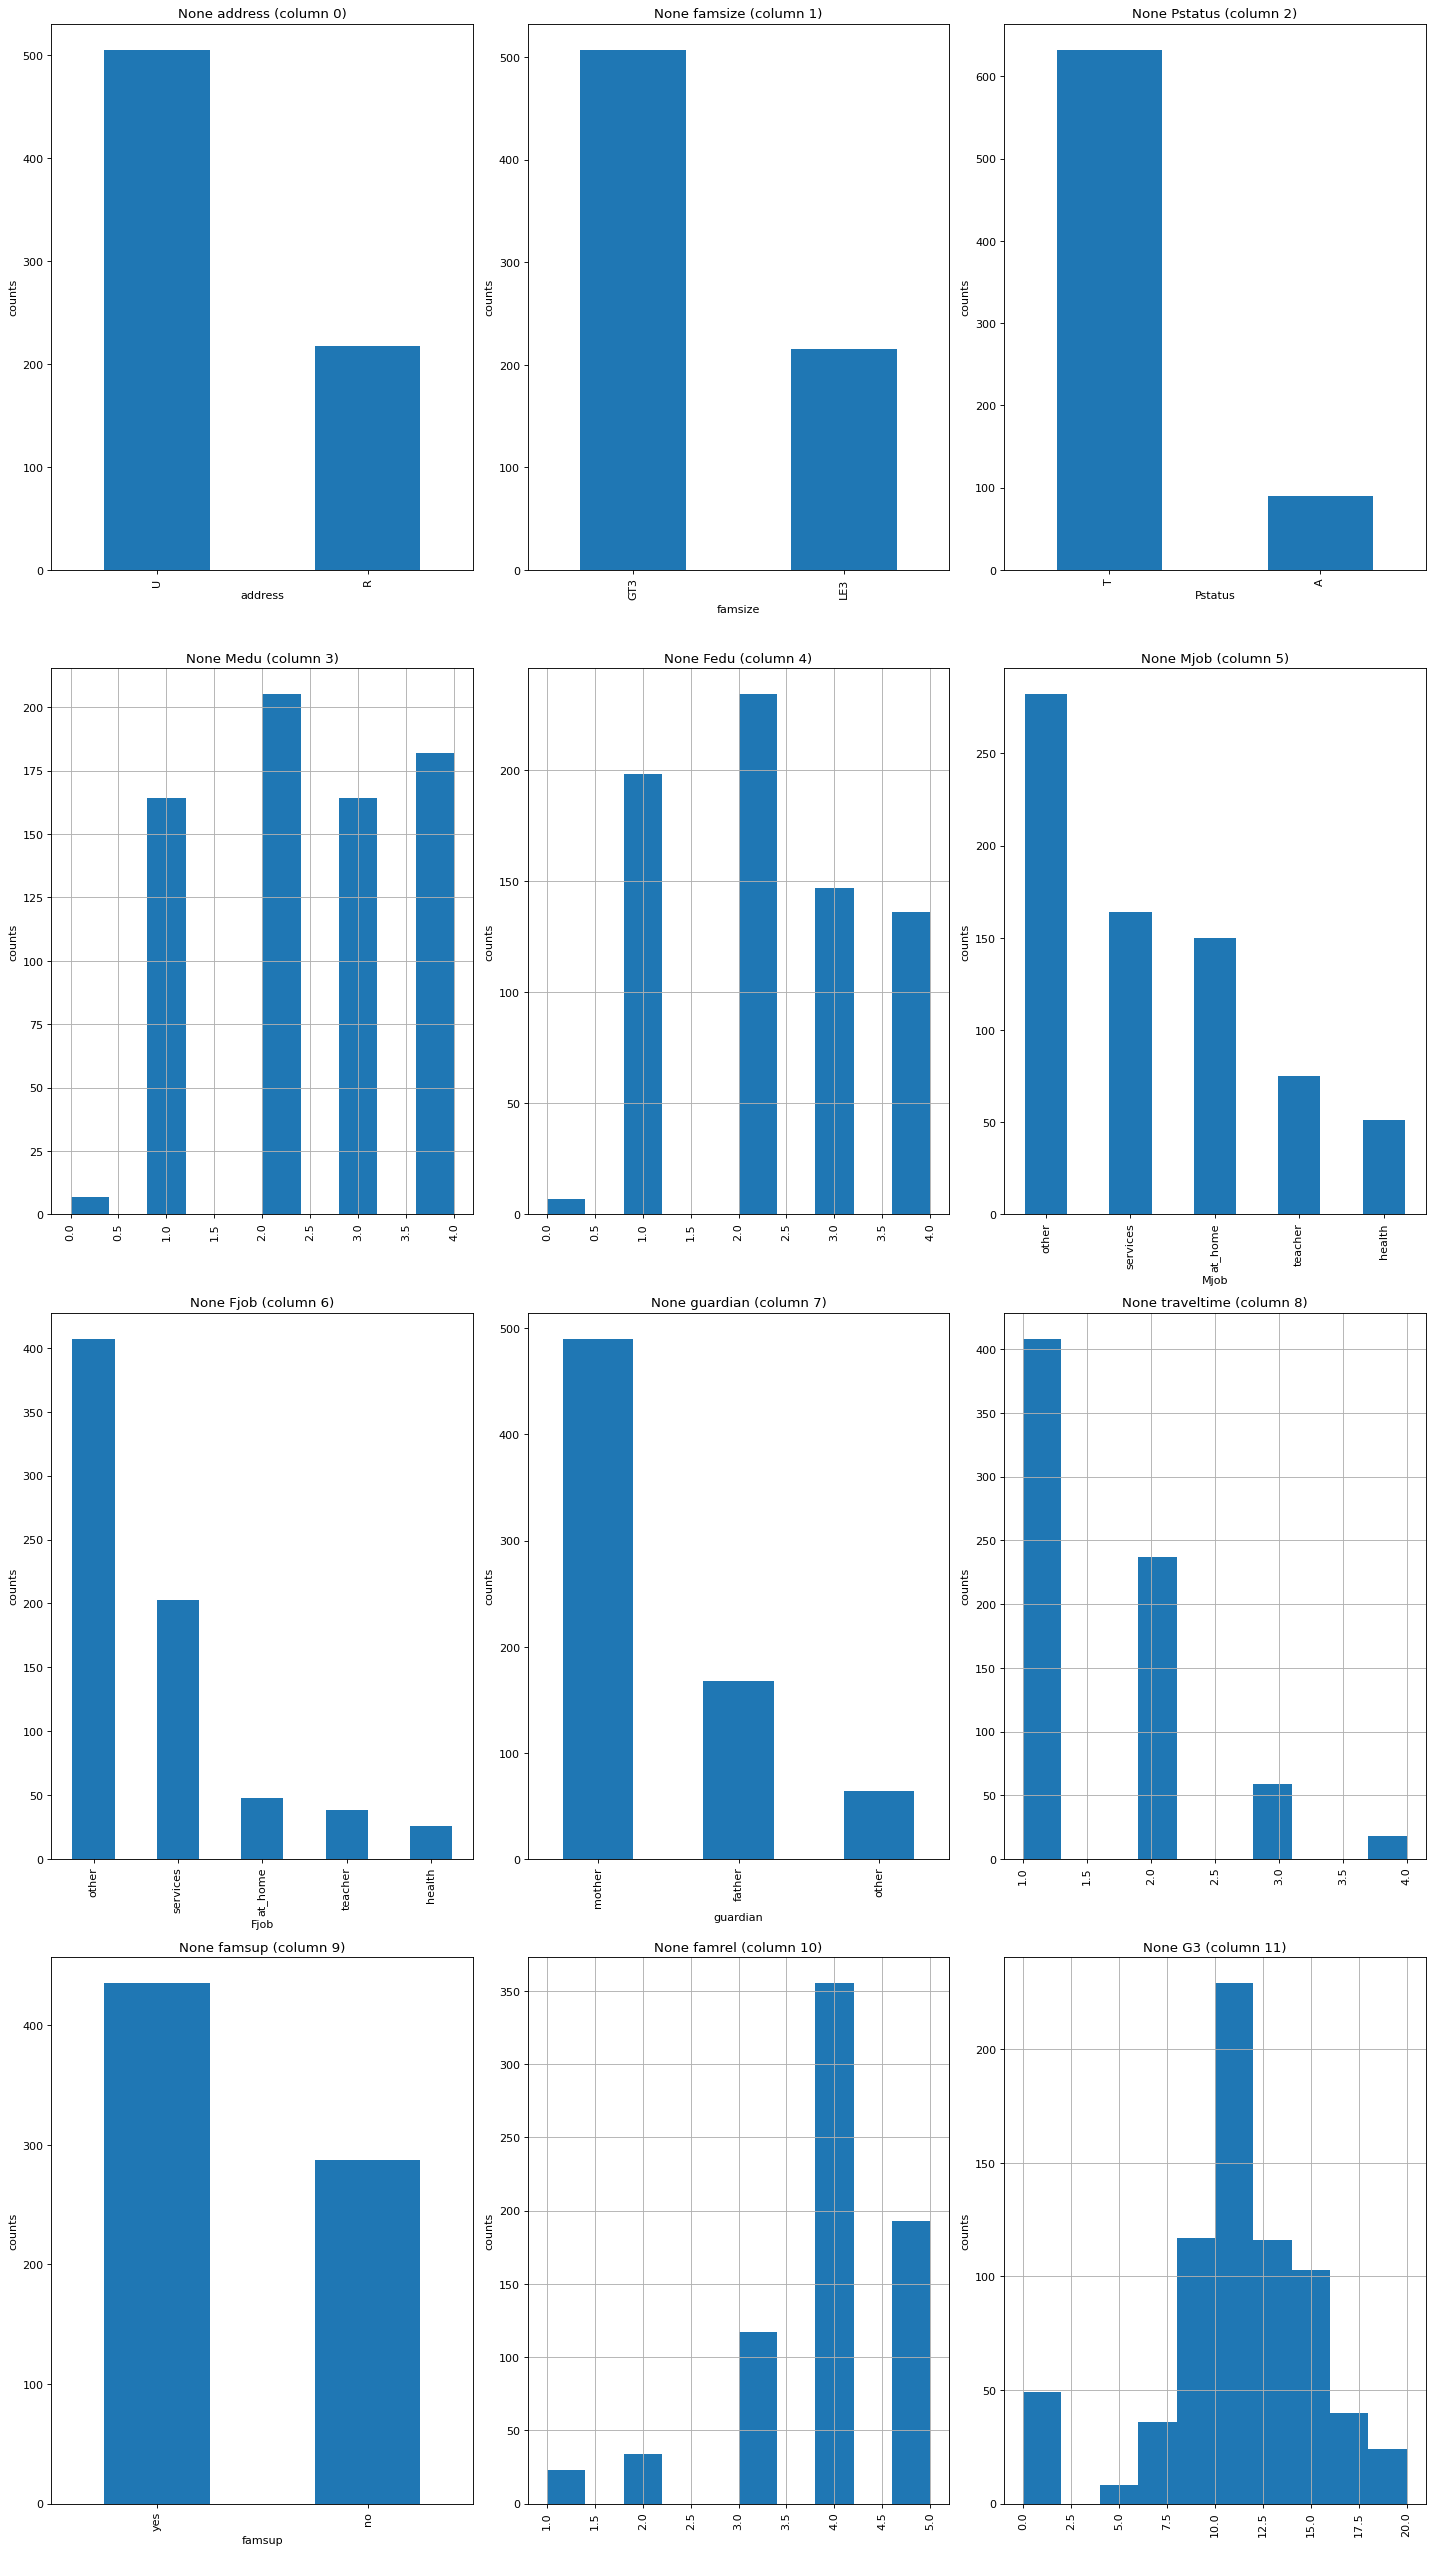

306 12


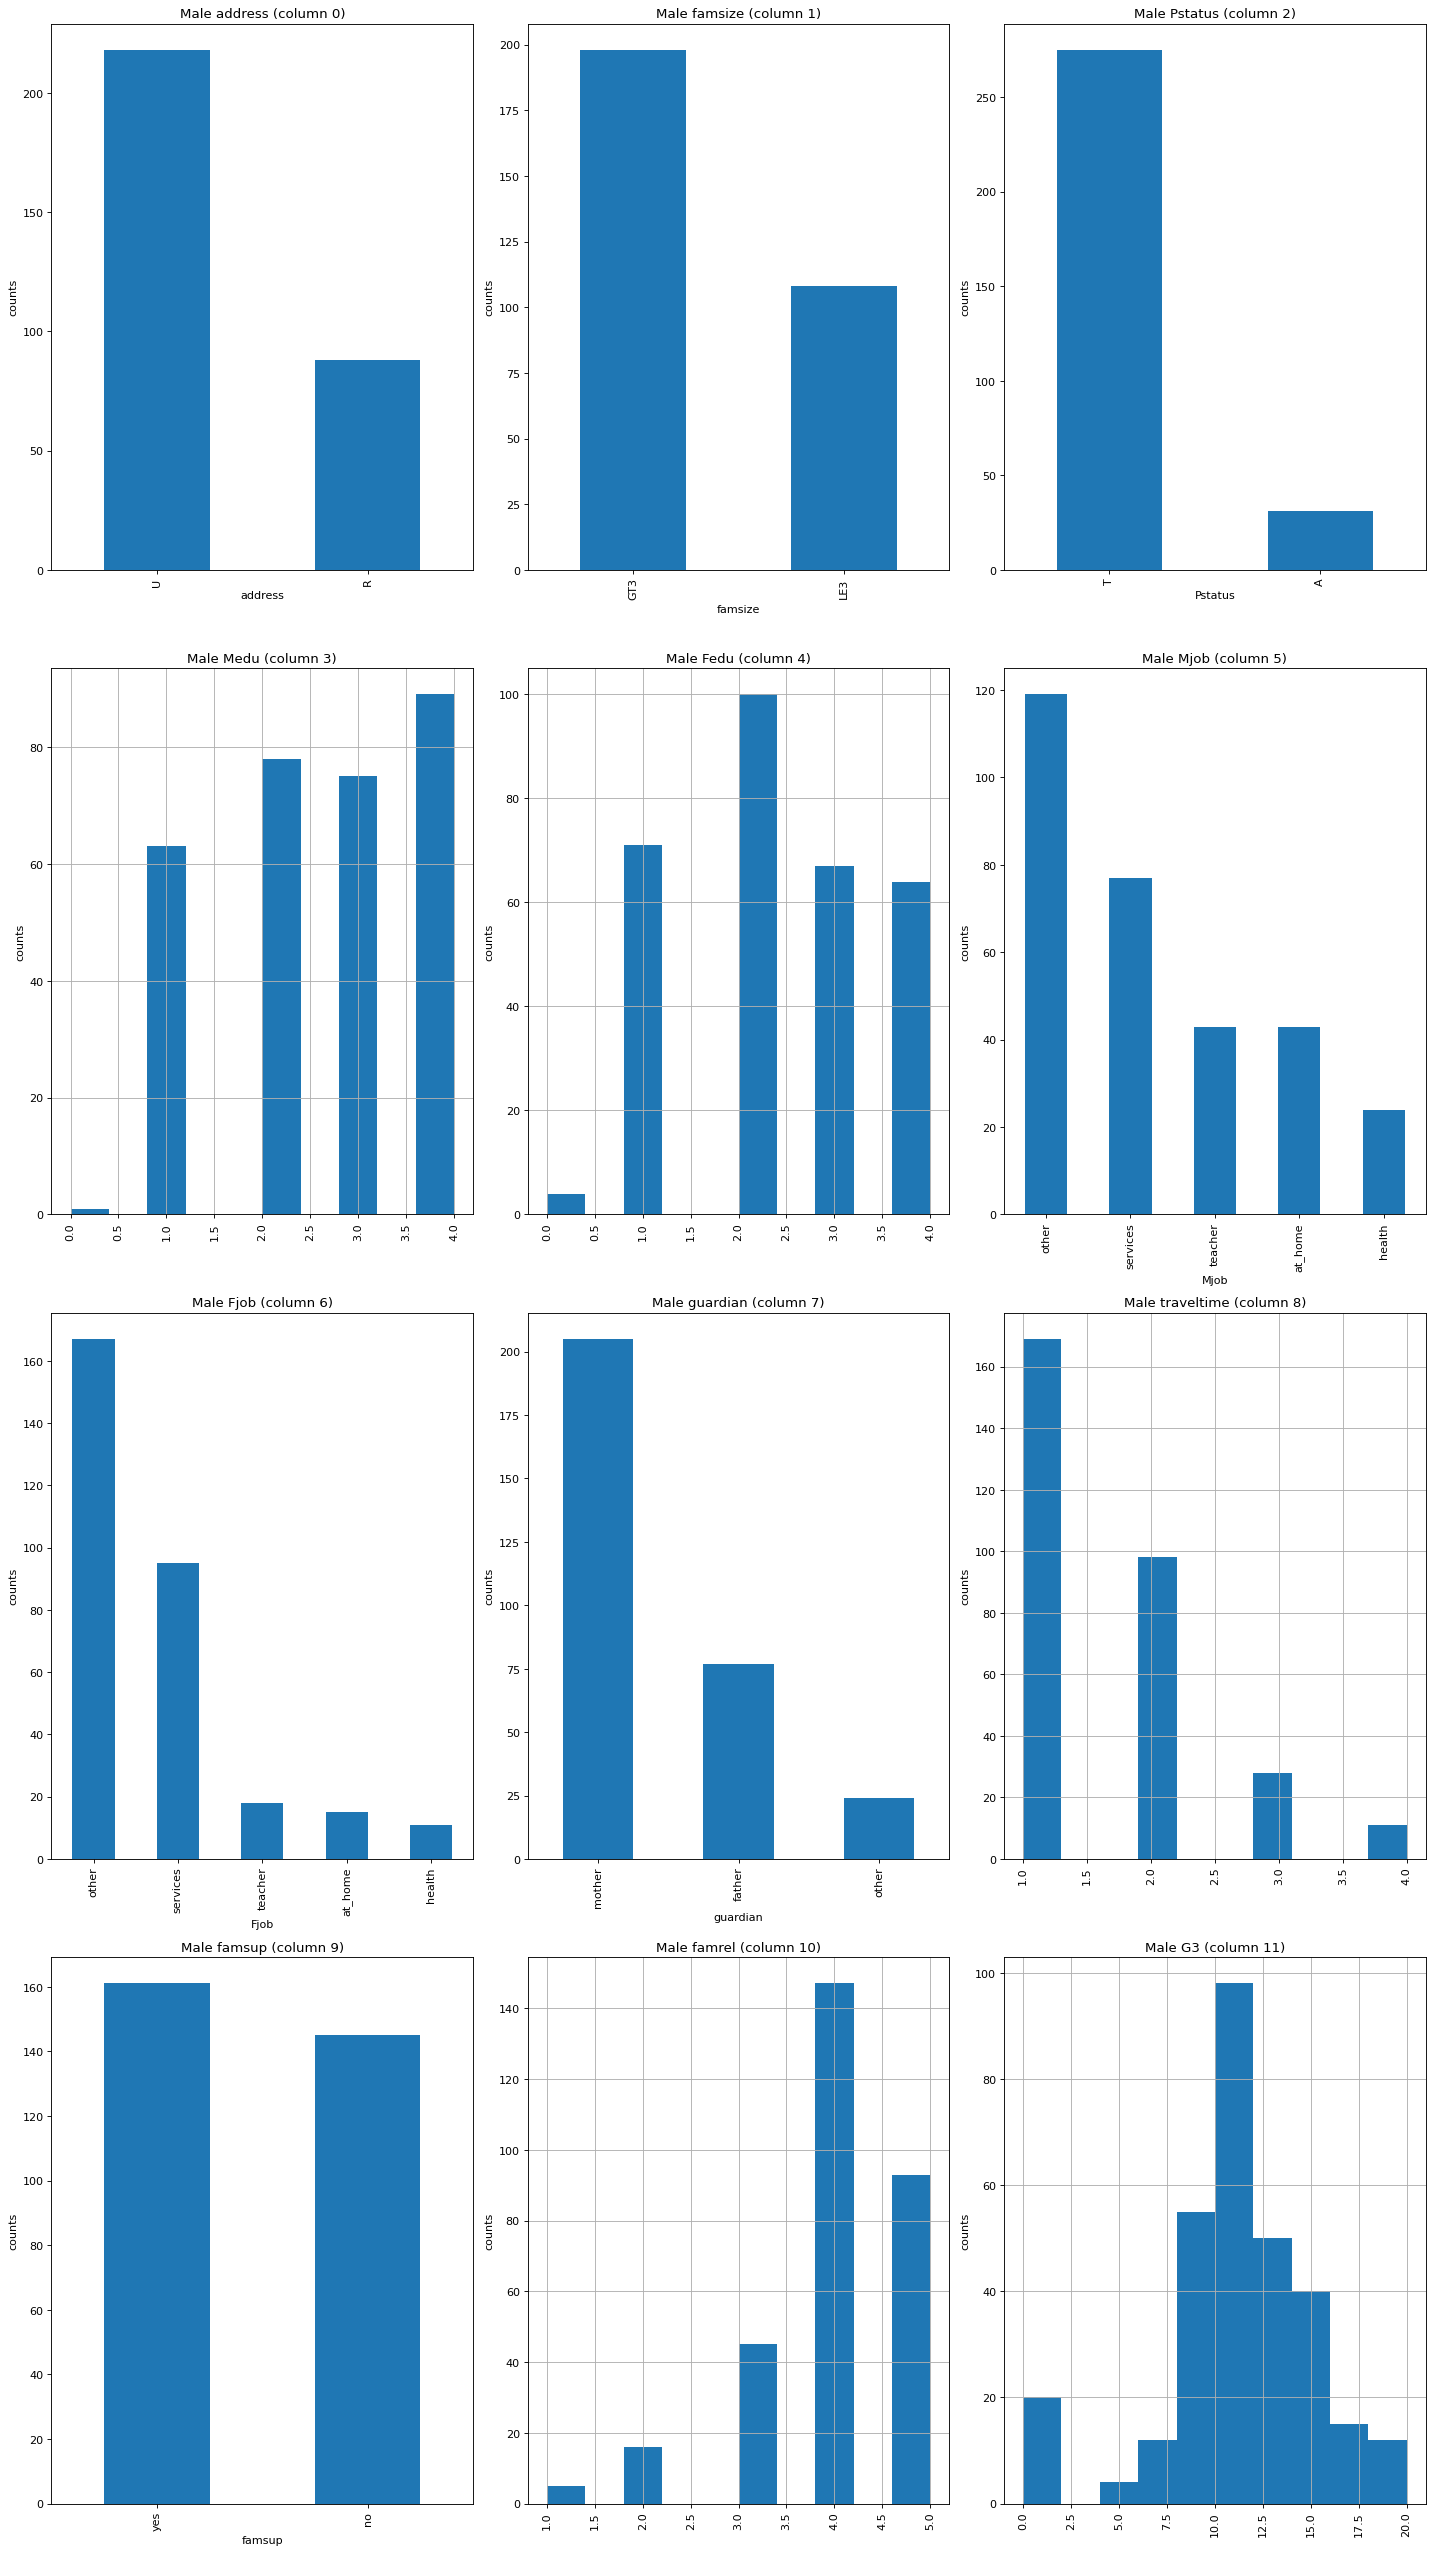

416 12


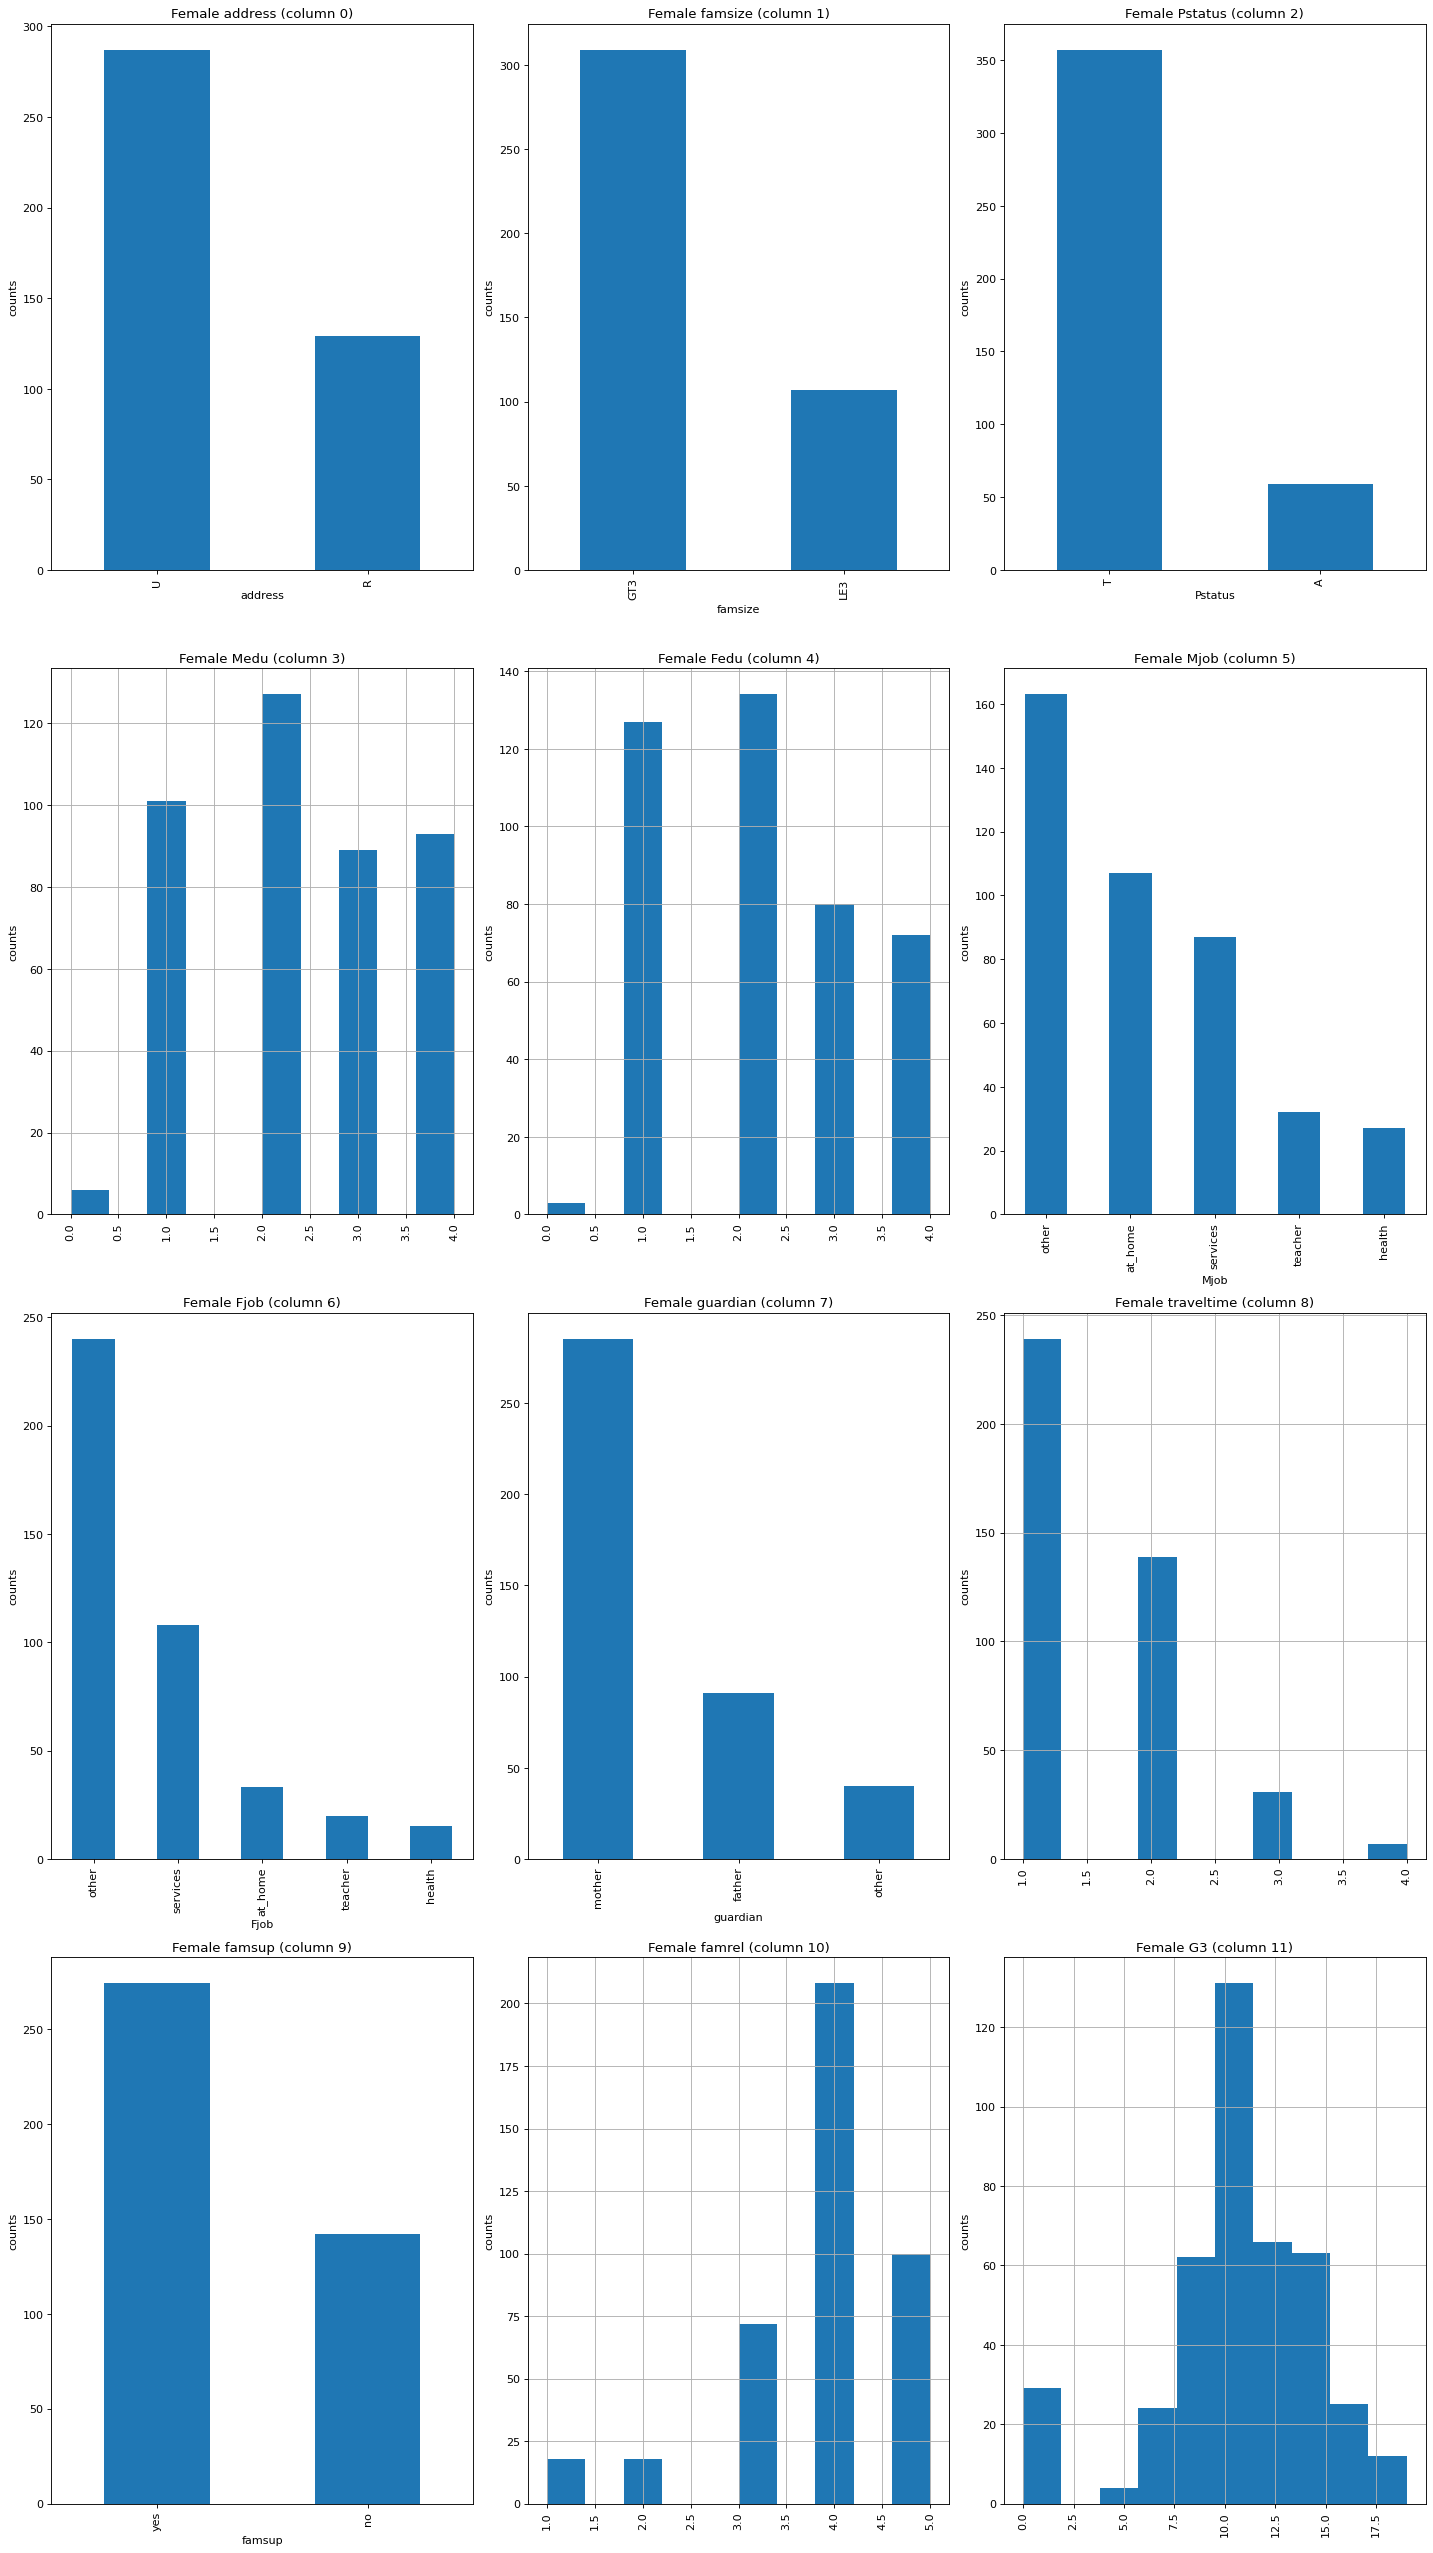

c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:71: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = data[variable].replace(['teacher', 'health', 'services', 'at_home', 'other'], [0, 1, 2, 3, 4])
c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[variable], data['G3'], s=density*5000, cmap='viridis', edgecolor='k', alpha=0.7)


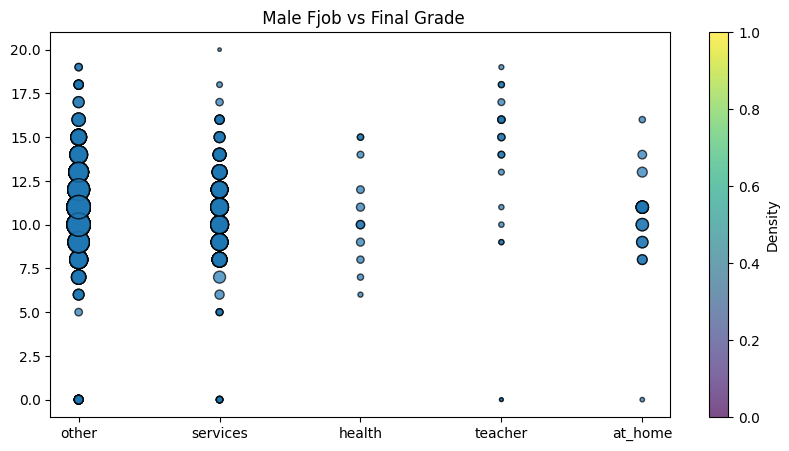

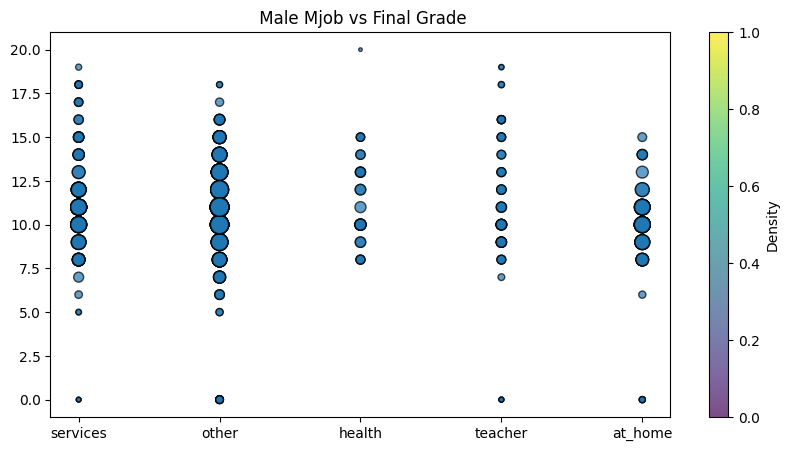

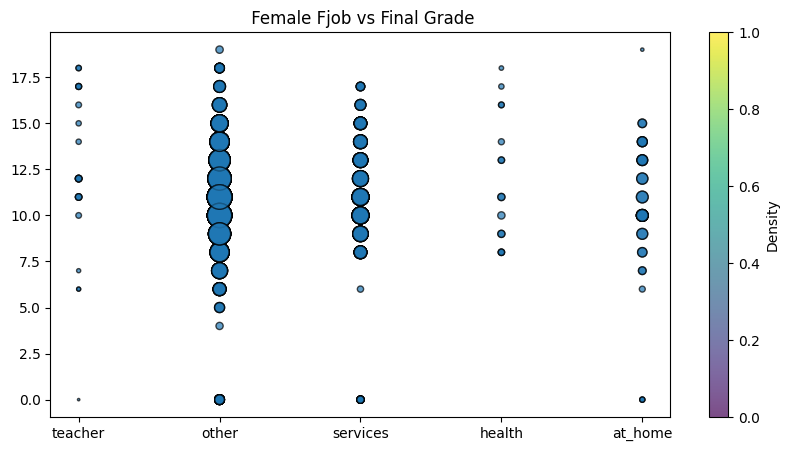

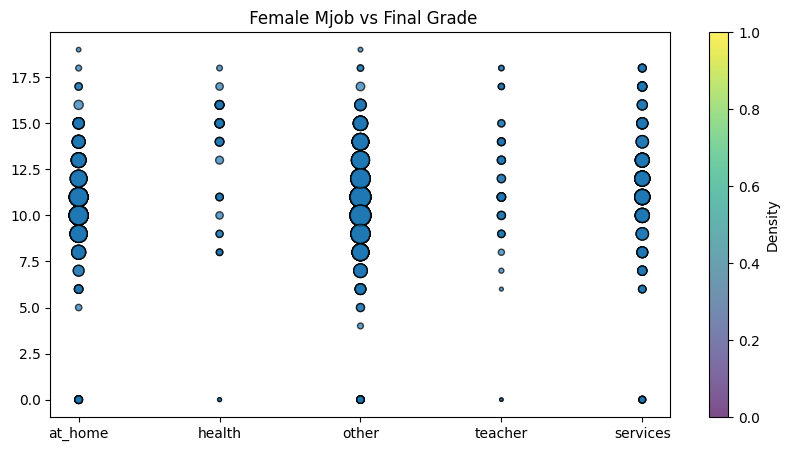

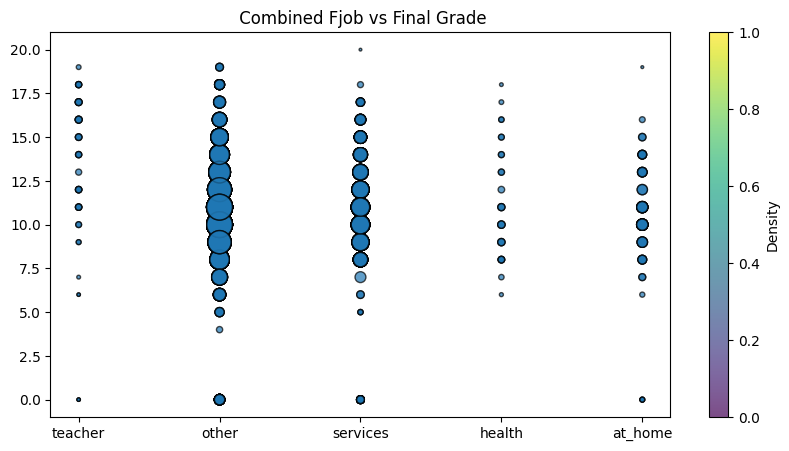

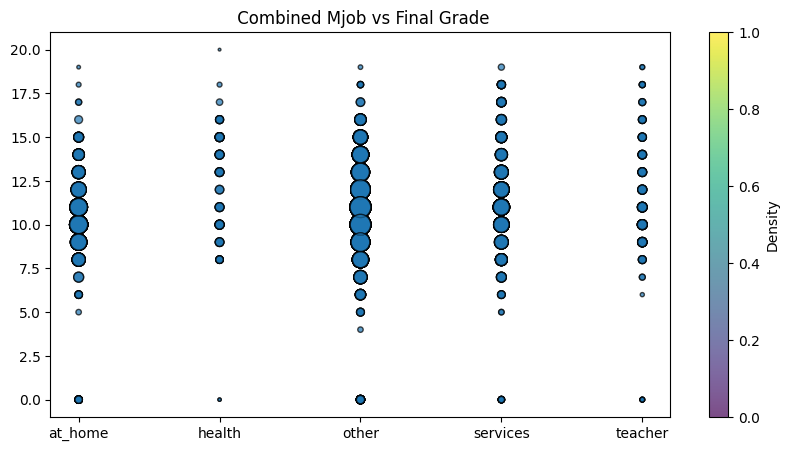

c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:87: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = data[variable].replace(['no', 'yes'], [0, 1])
c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:94: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[variable], data['G3'], s=density*5000, cmap='viridis', edgecolor='k', alpha=0.7)


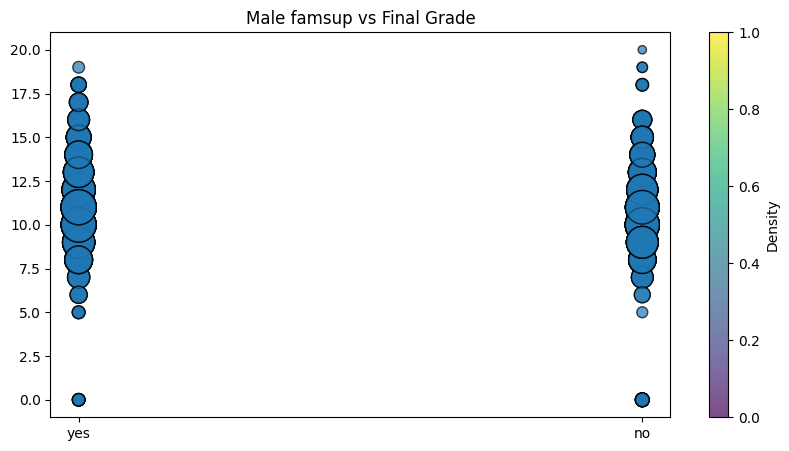

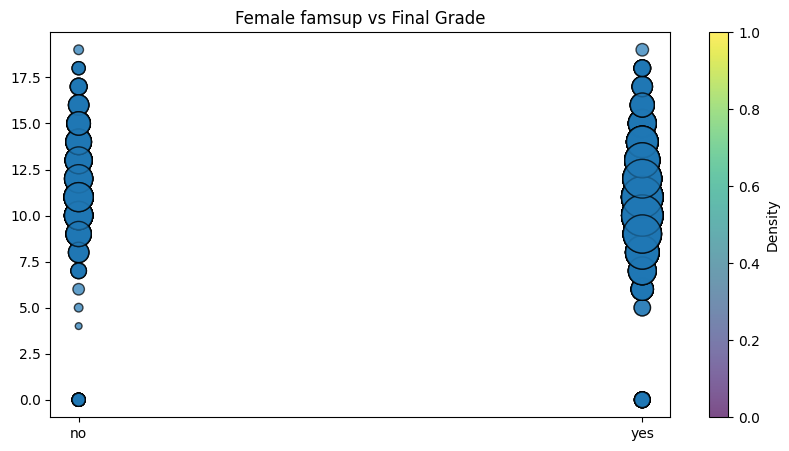

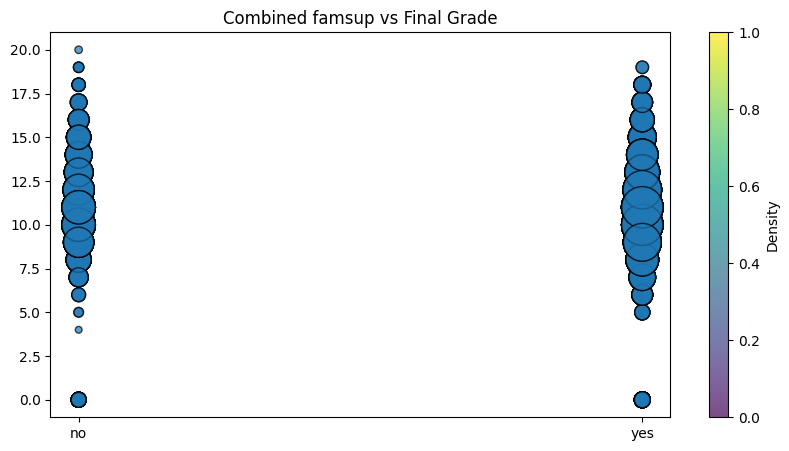

c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:103: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = data[variable].replace(['mother', 'father', 'other'], [0, 1, 2])
c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:110: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[variable], data['G3'], s=density*5000, cmap='viridis', edgecolor='k', alpha=0.7)


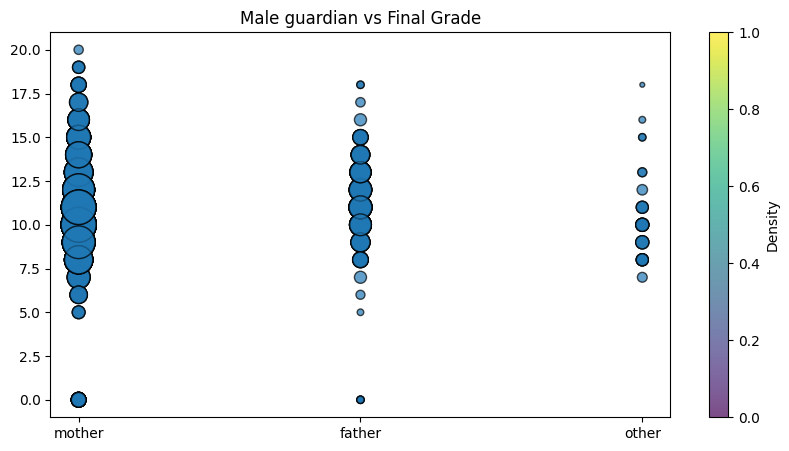

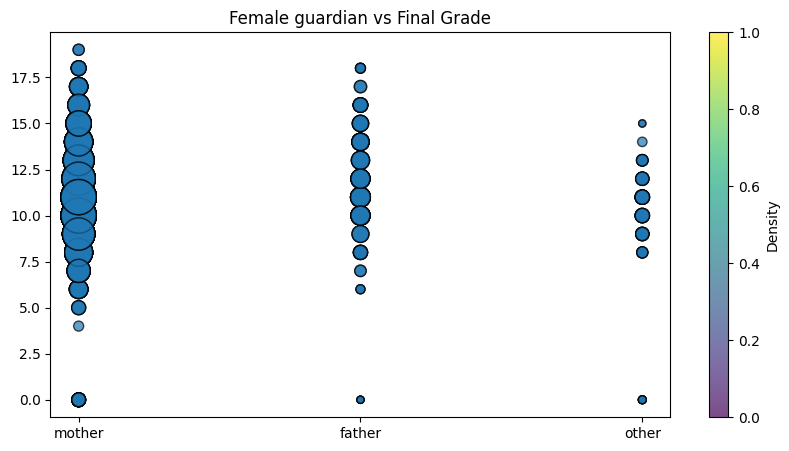

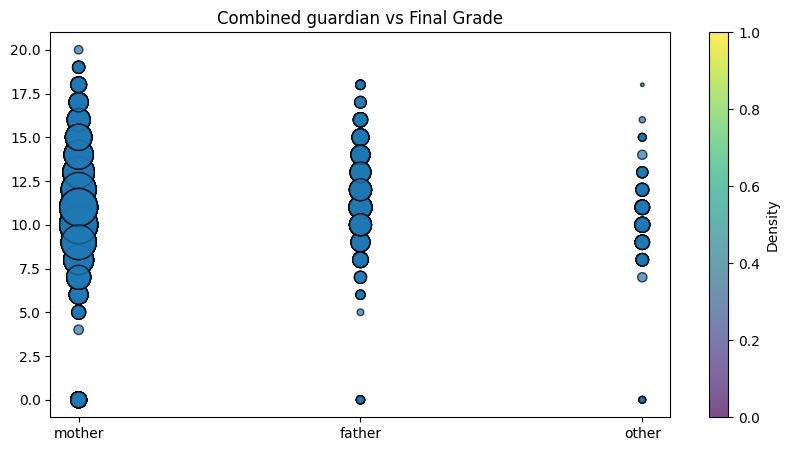

c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:119: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = data[variable].replace(['GT3','LE3'], [0, 1])
c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:126: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[variable], data['G3'], s=density*5000, cmap='viridis', edgecolor='k', alpha=0.7)


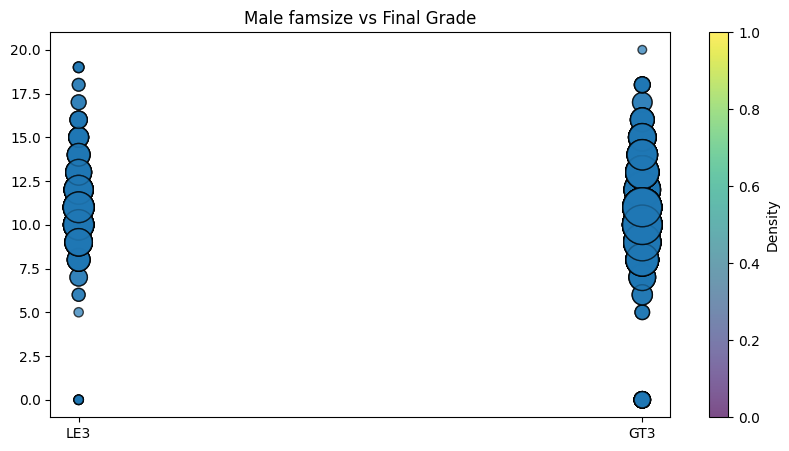

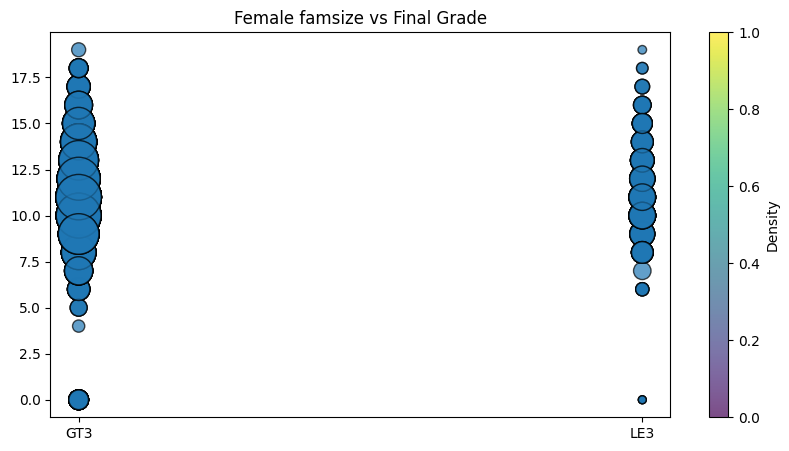

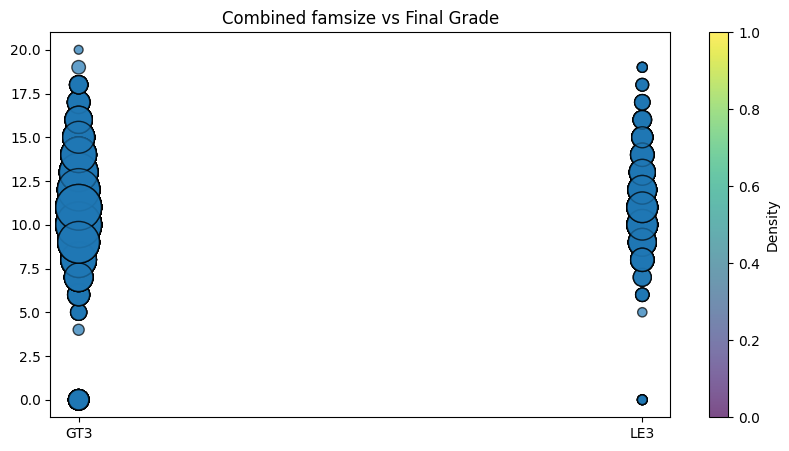

c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:134: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = data[variable].replace(['U', 'R'], [0, 1])
c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:141: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[variable], data['G3'], s=density*5000, cmap='viridis', edgecolor='k', alpha=0.7)


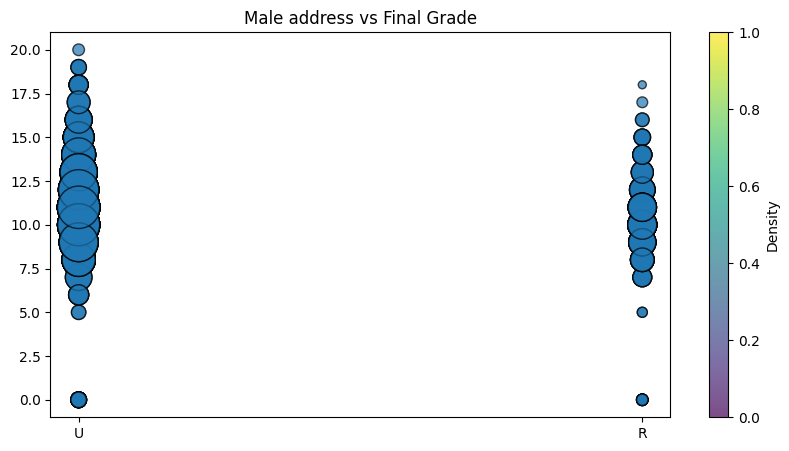

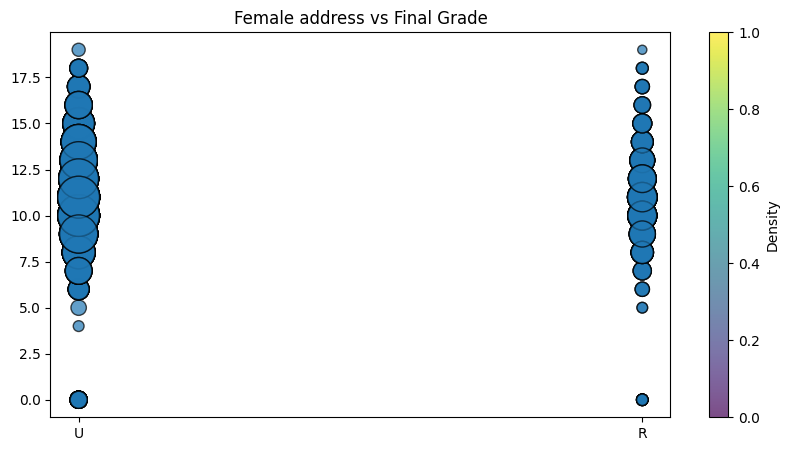

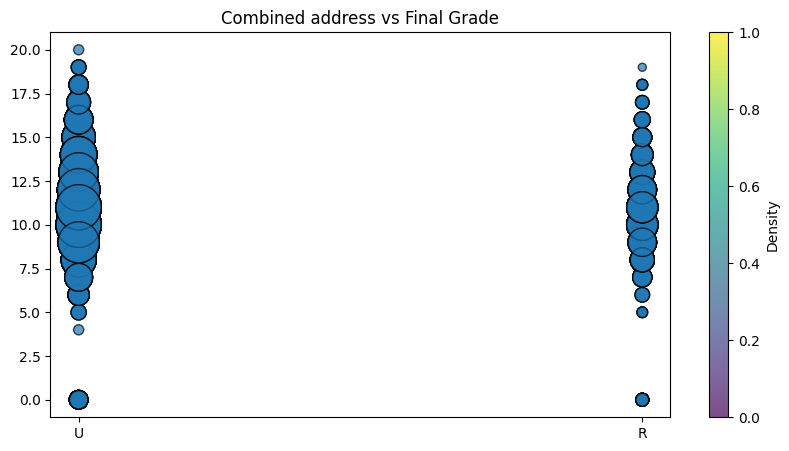

Count of value : 167


c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:156: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Mjob'] = df['Mjob'].replace(['teacher', 'health', 'services', 'at_home', 'other'], [0, 1, 2, 3, 4])
c:\Users\danie\OneDrive - ITU\Desktop\ITU\3. Semester\High performance game programming\datamining\Assignment 2\Preprocessing.py:157: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Fjob'] = df['Fjob'].replace(['teacher', 'health', 'services', 'at_ho

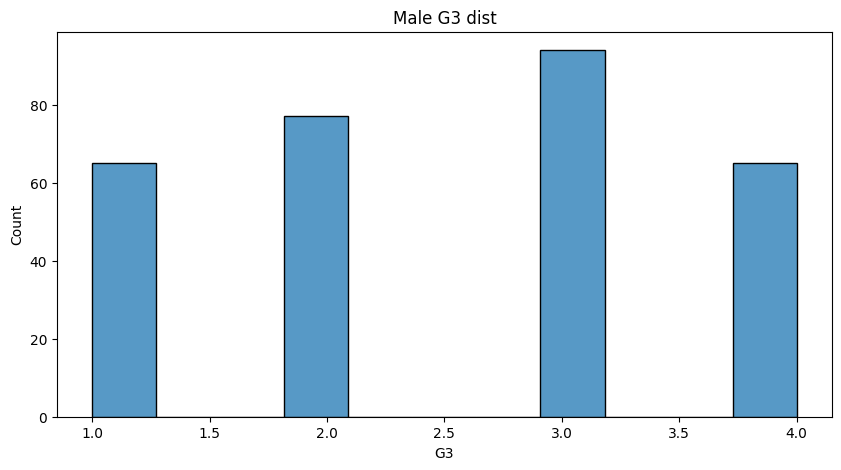

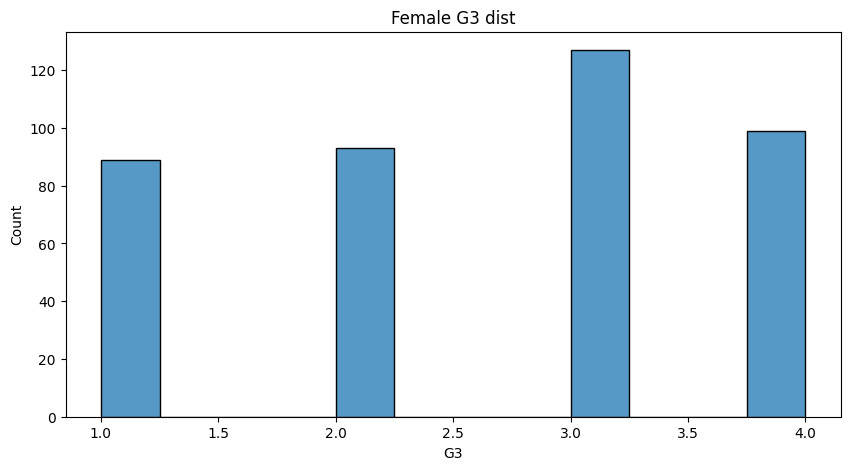

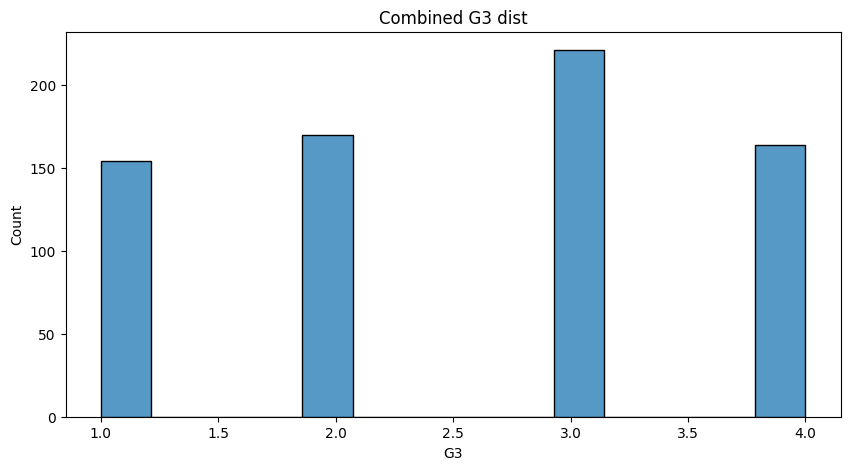

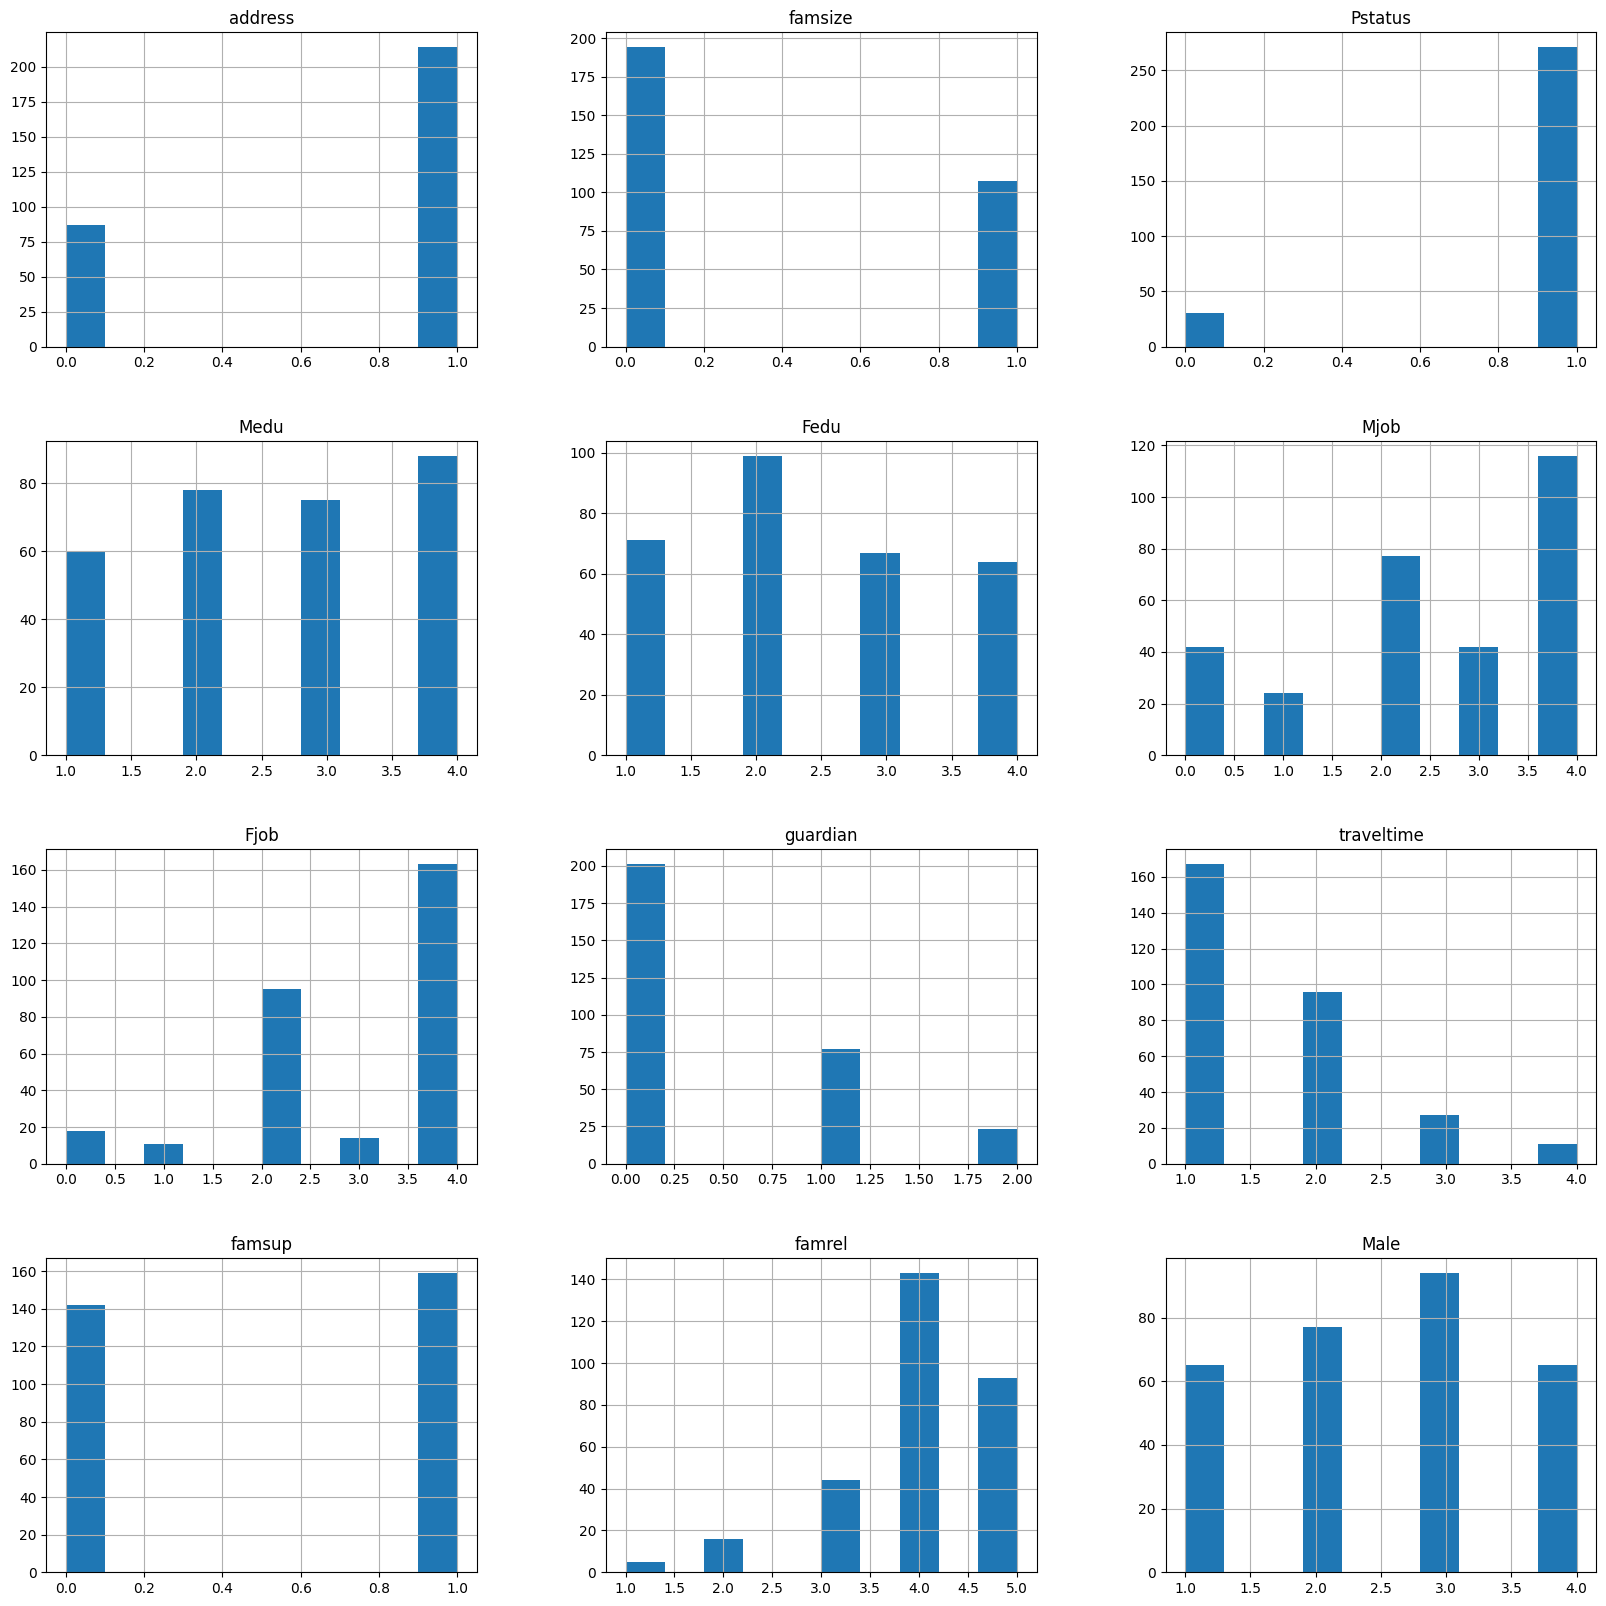

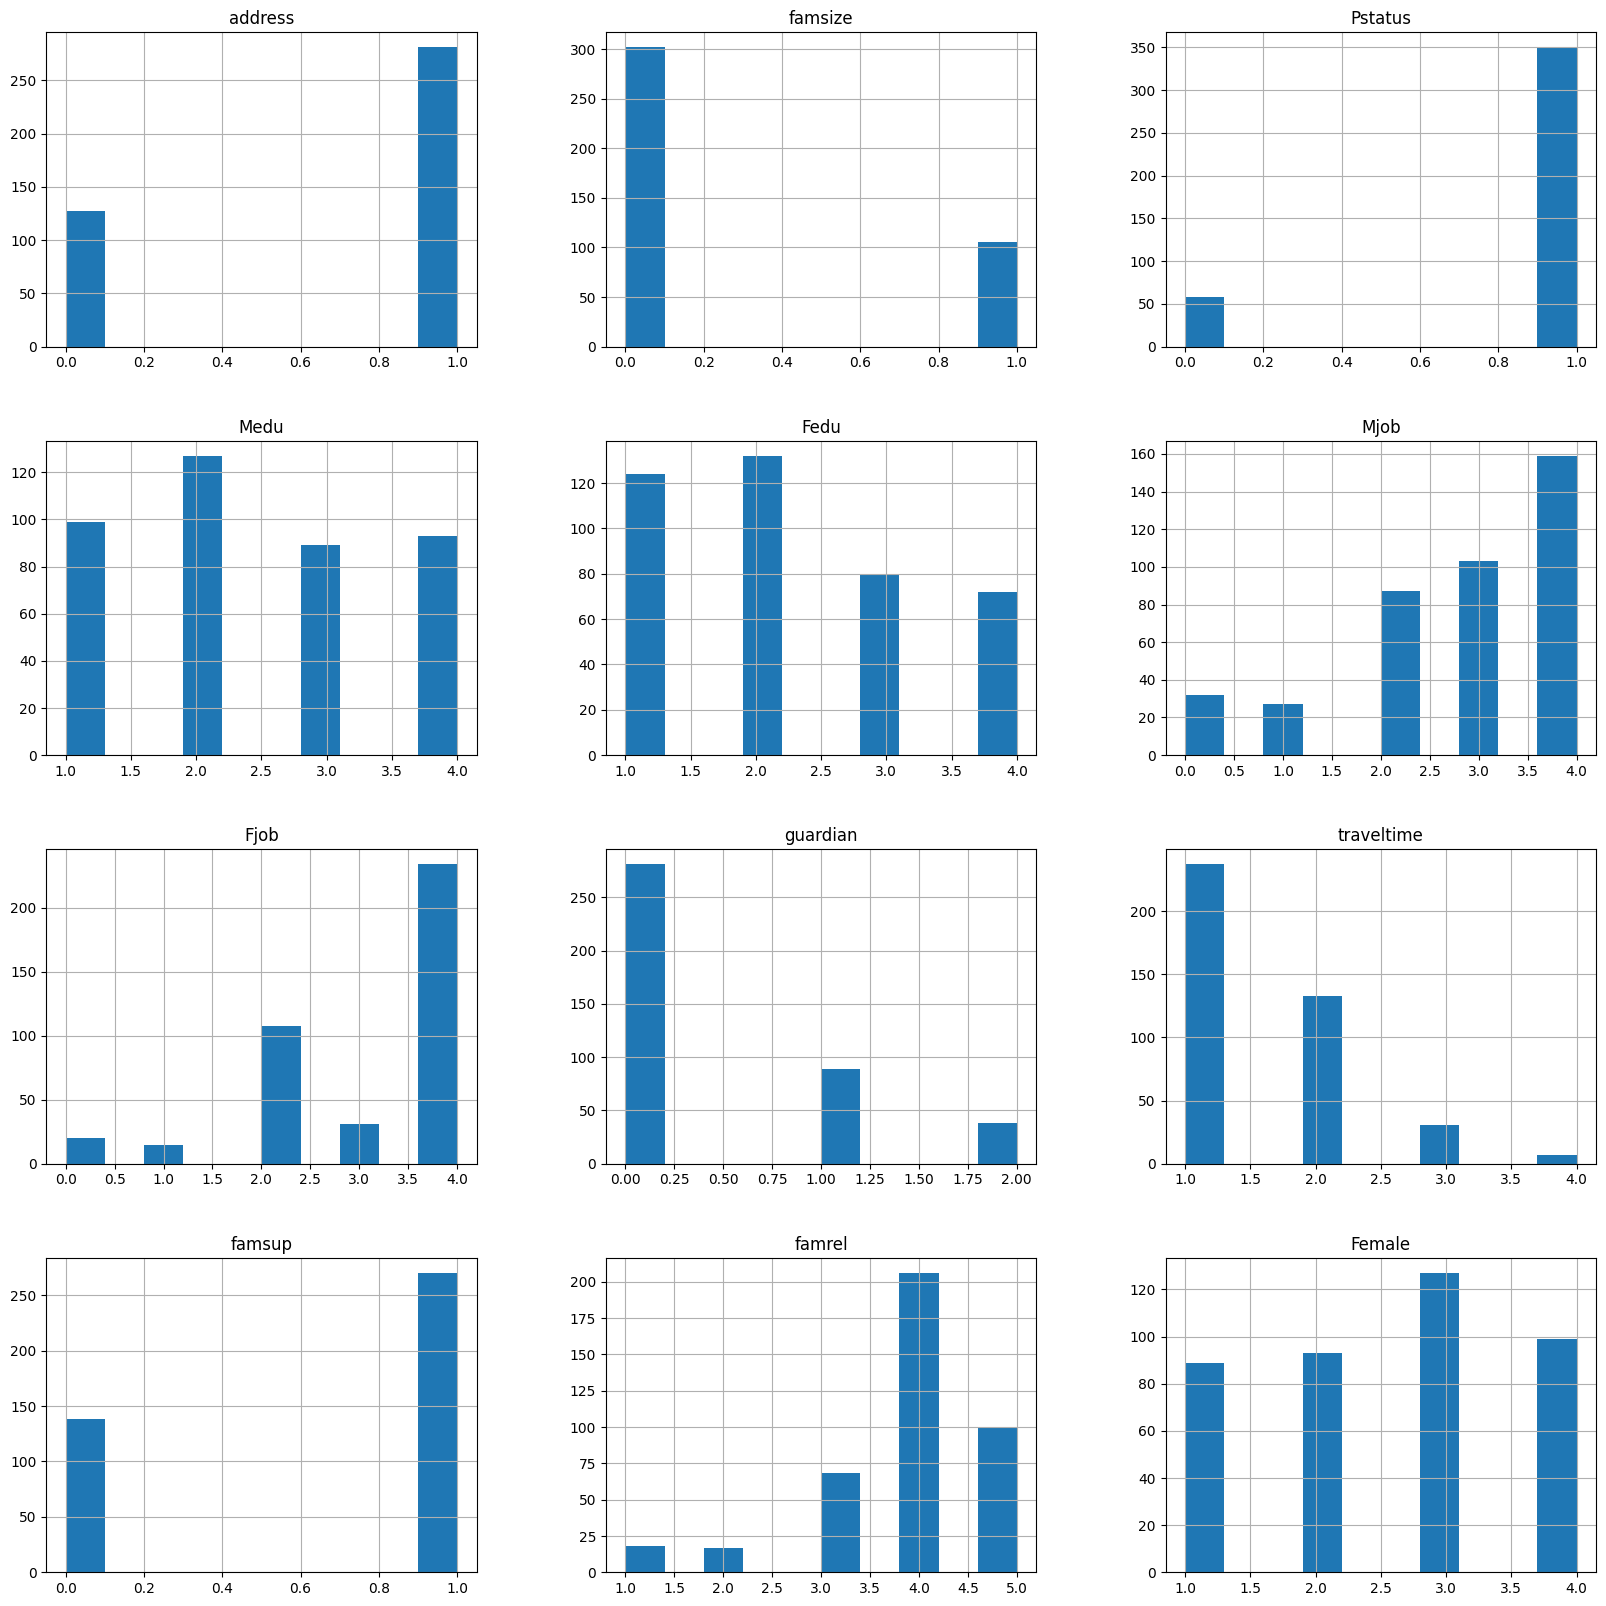

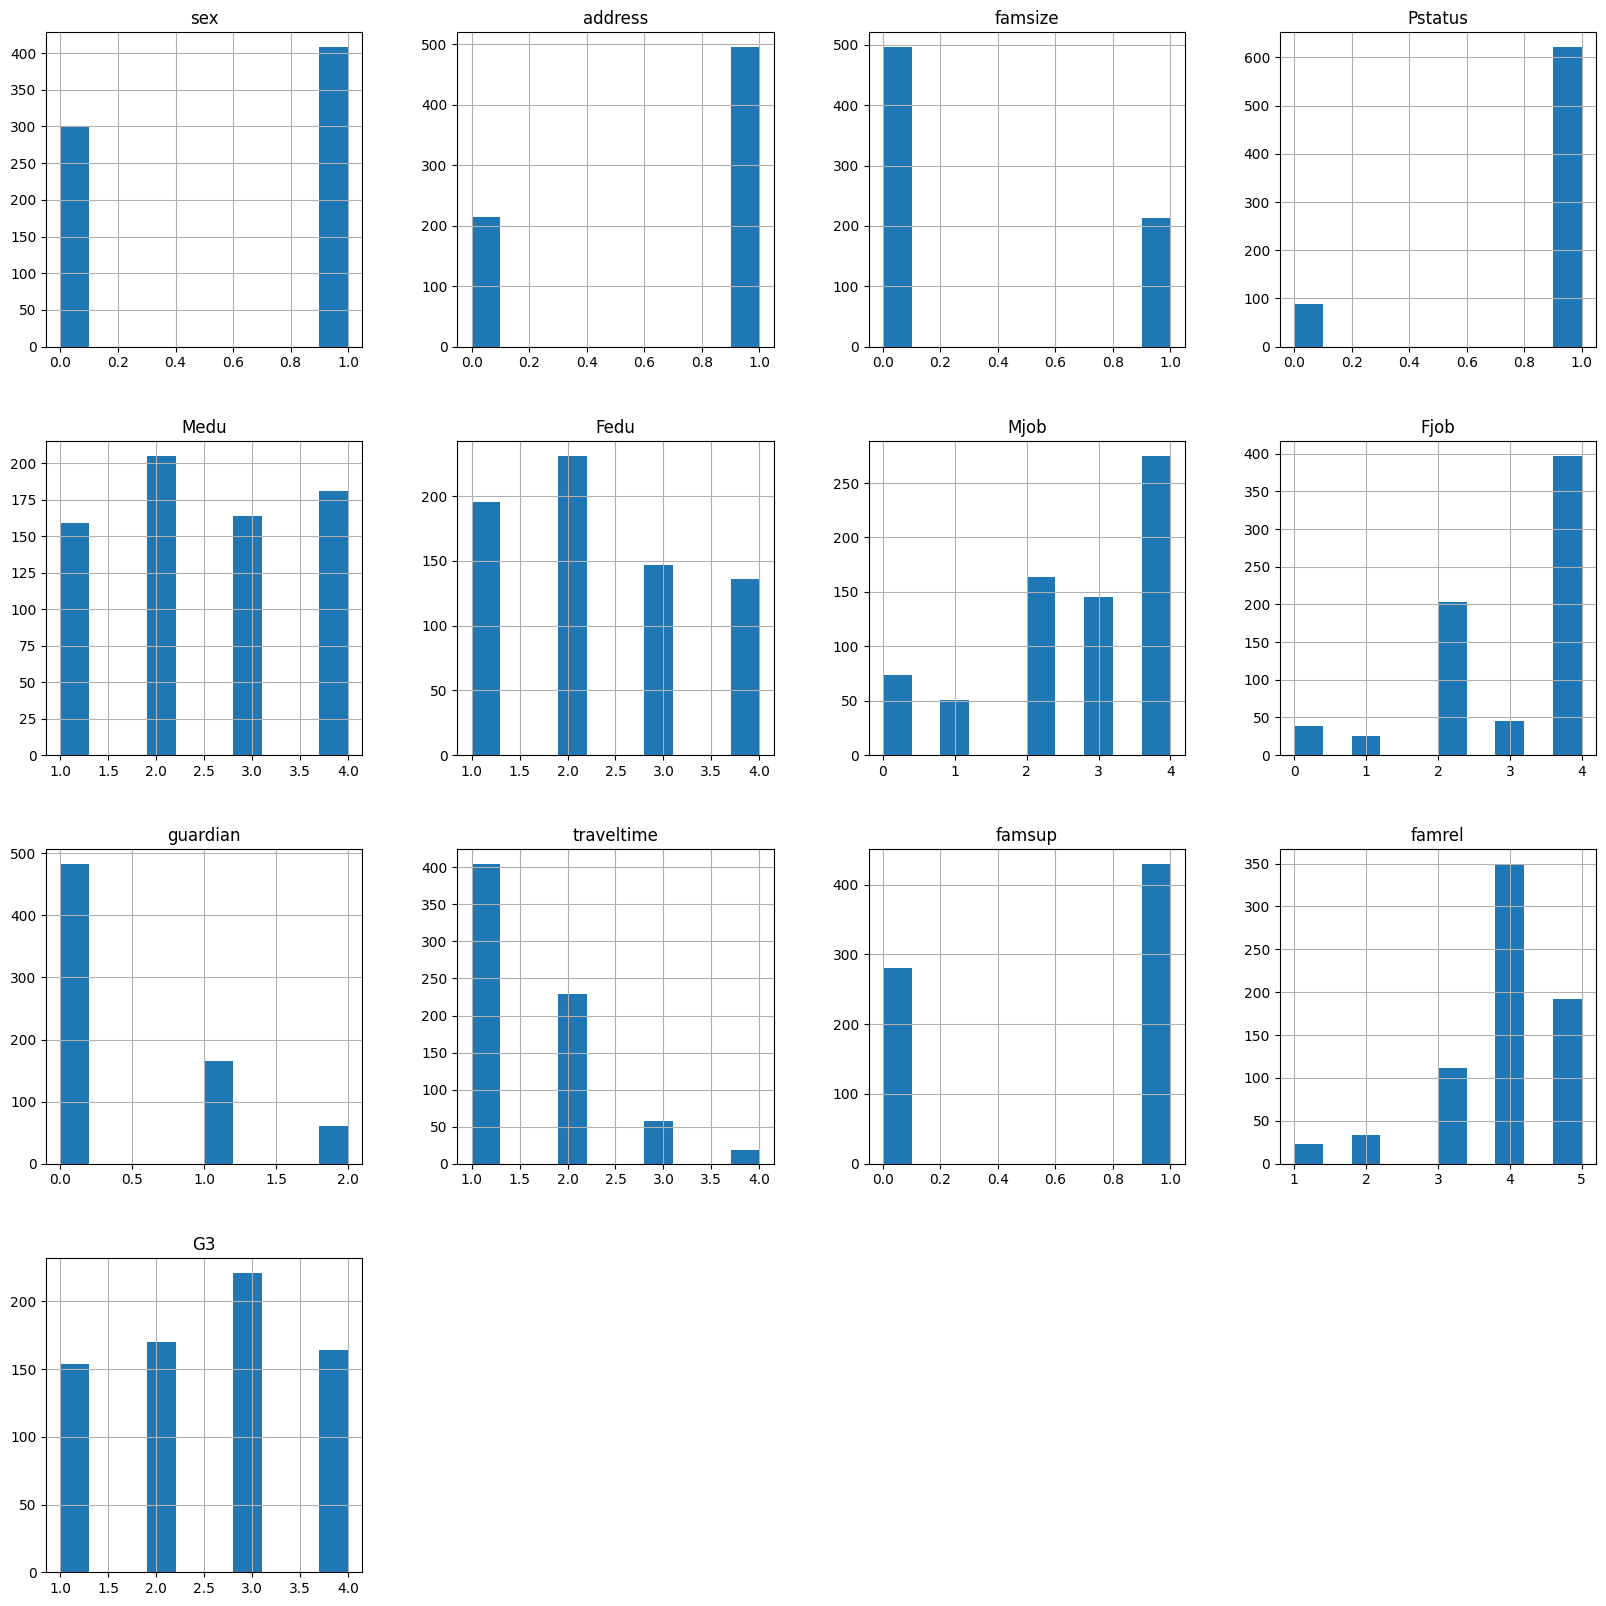

address
address
1    0.710963
0    0.289037
Name: proportion, dtype: float64
Male

famsize
famsize
0    0.644518
1    0.355482
Name: proportion, dtype: float64
Male

Pstatus
Pstatus
1    0.900332
0    0.099668
Name: proportion, dtype: float64
Male

Medu
Medu
4    0.292359
2    0.259136
3    0.249169
1    0.199336
Name: proportion, dtype: float64
Male

Fedu
Fedu
2    0.328904
1    0.235880
3    0.222591
4    0.212625
Name: proportion, dtype: float64
Male

Mjob
Mjob
4    0.385382
2    0.255814
0    0.139535
3    0.139535
1    0.079734
Name: proportion, dtype: float64
Male

Fjob
Fjob
4    0.541528
2    0.315615
0    0.059801
3    0.046512
1    0.036545
Name: proportion, dtype: float64
Male

guardian
guardian
0    0.667774
1    0.255814
2    0.076412
Name: proportion, dtype: float64
Male

traveltime
traveltime
1    0.554817
2    0.318937
3    0.089701
4    0.036545
Name: proportion, dtype: float64
Male

famsup
famsup
1    0.528239
0    0.471761
Name: proportion, dtype: float64
Male

famrel

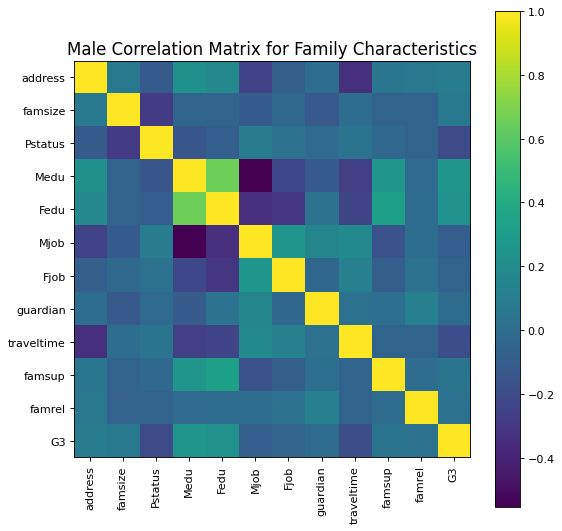

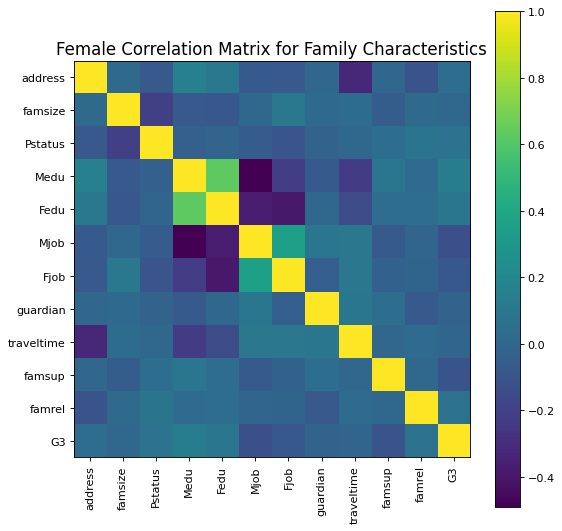

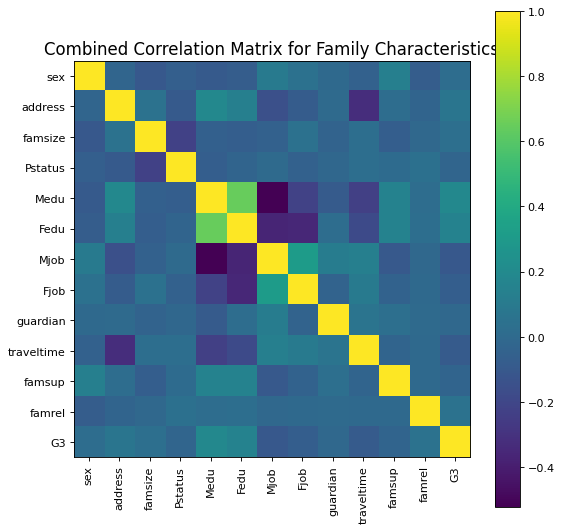

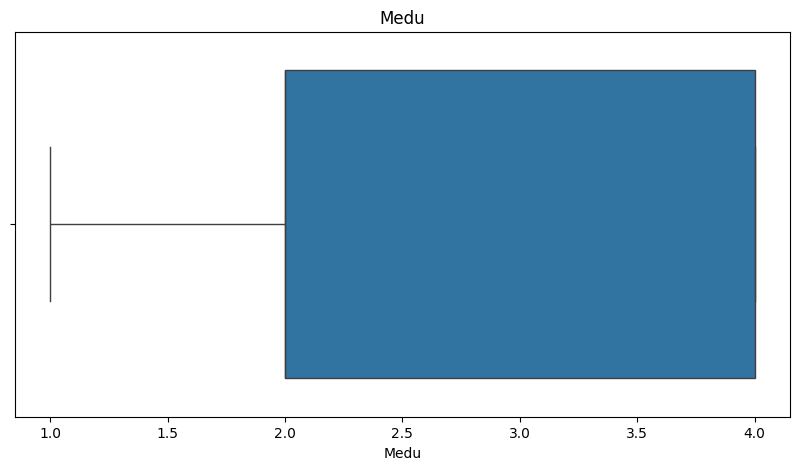

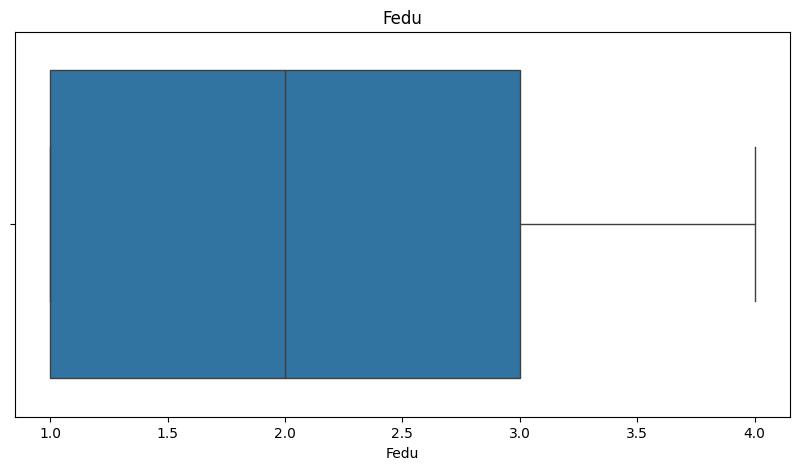

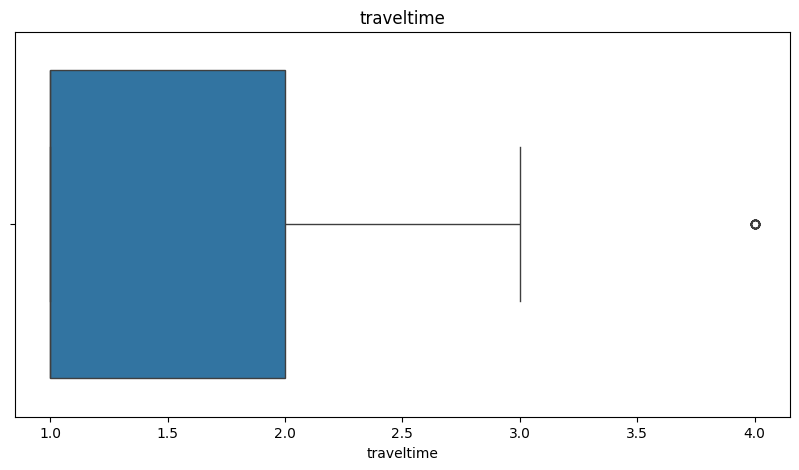

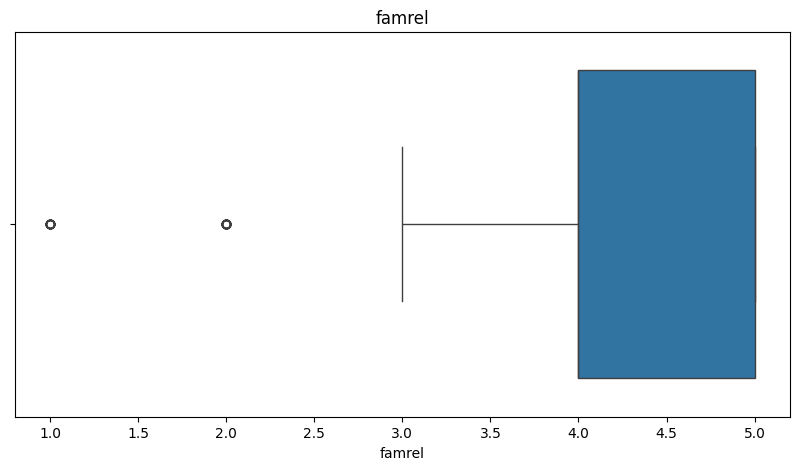

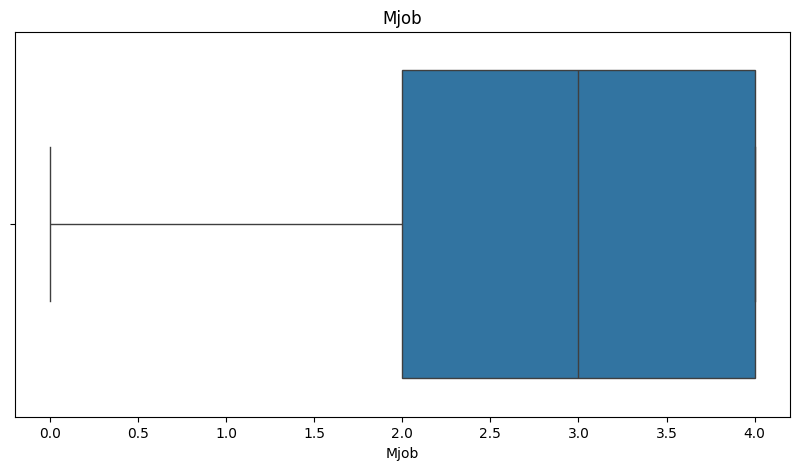

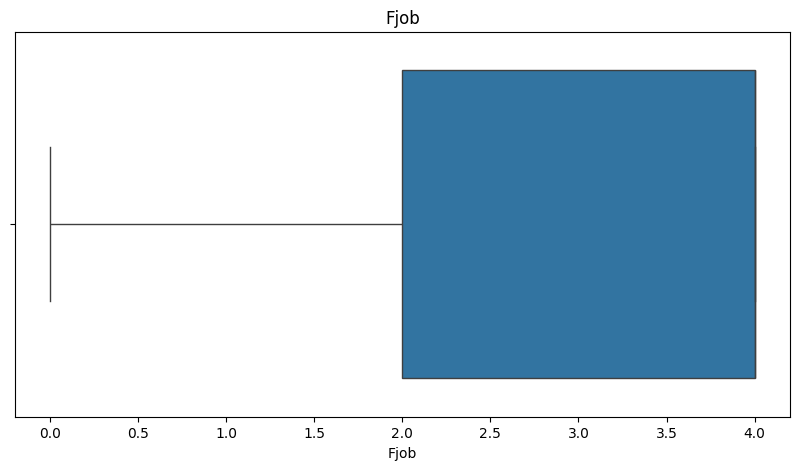

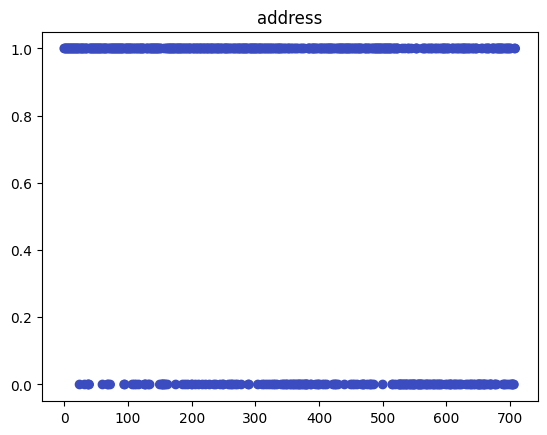

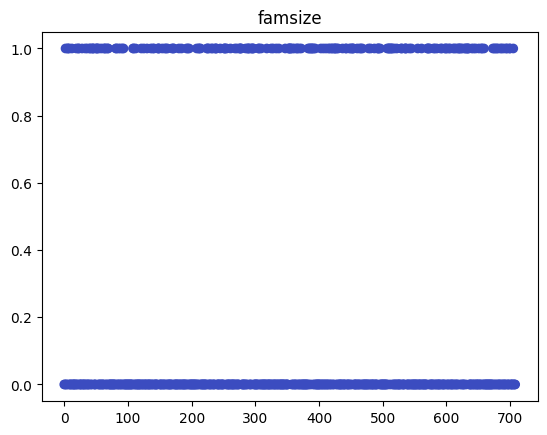

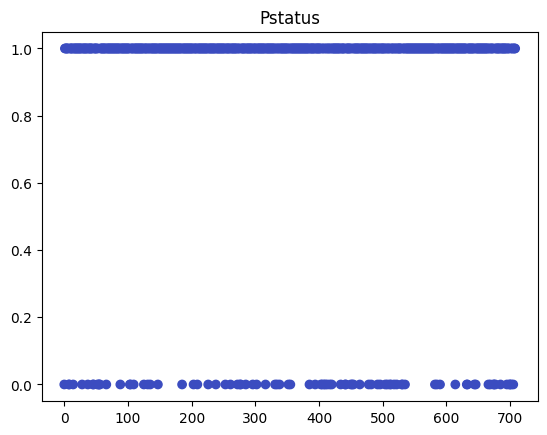

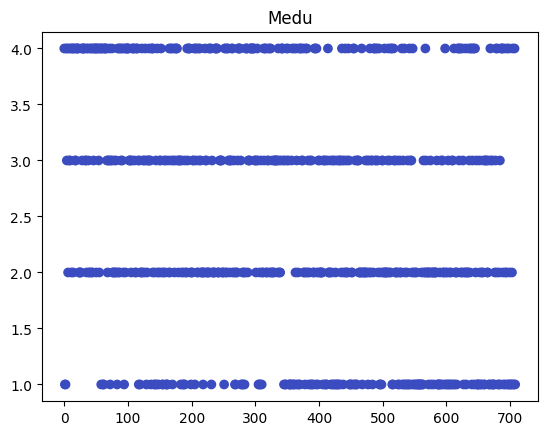

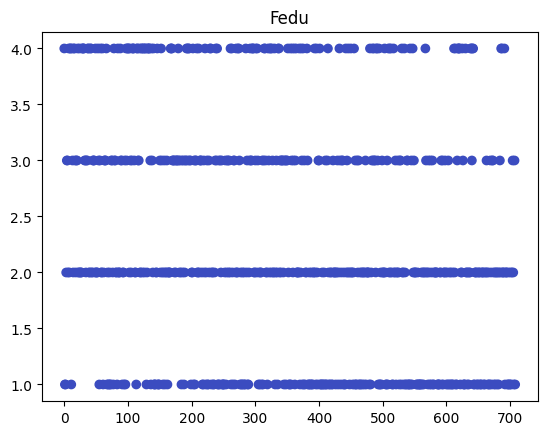

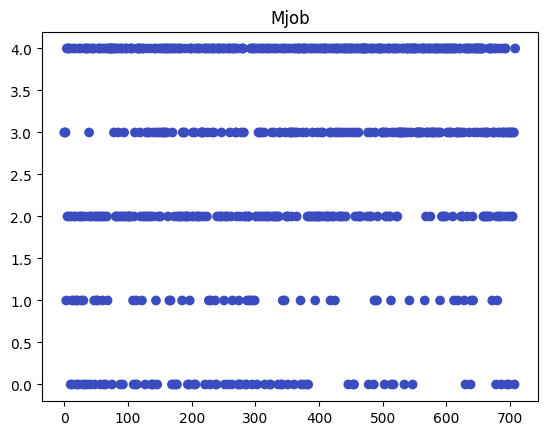

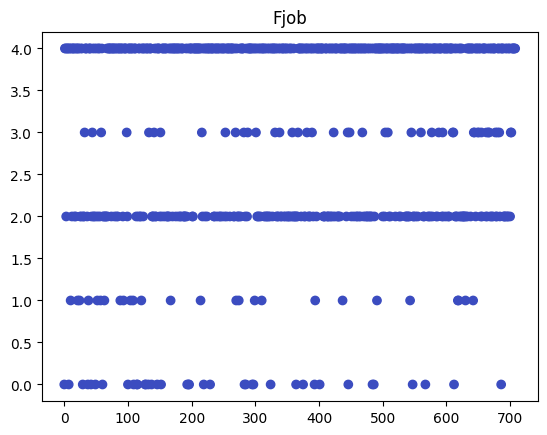

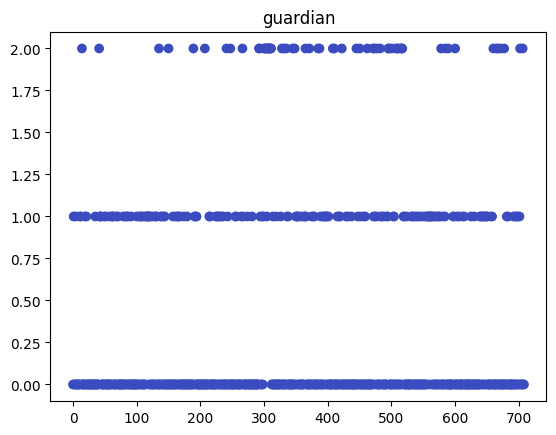

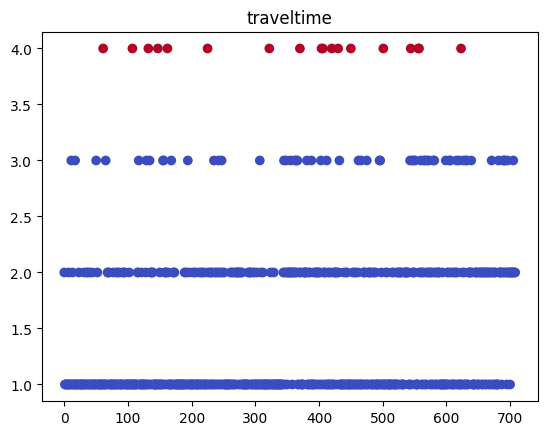

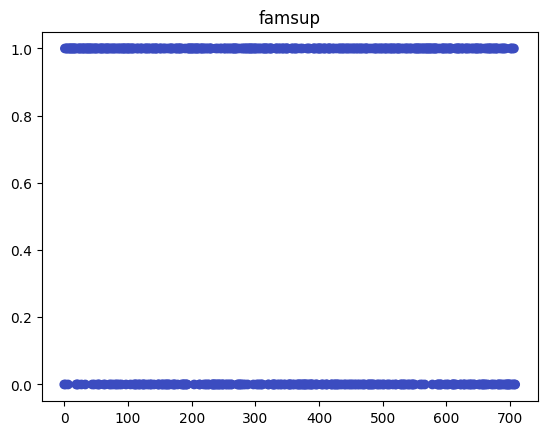

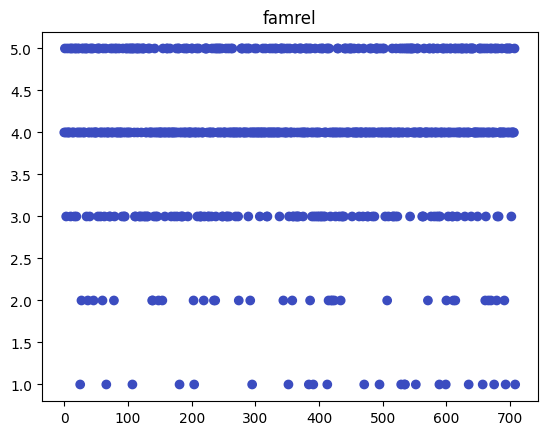

Pearson correlation between Fedu and G3: 0.2286488691596239


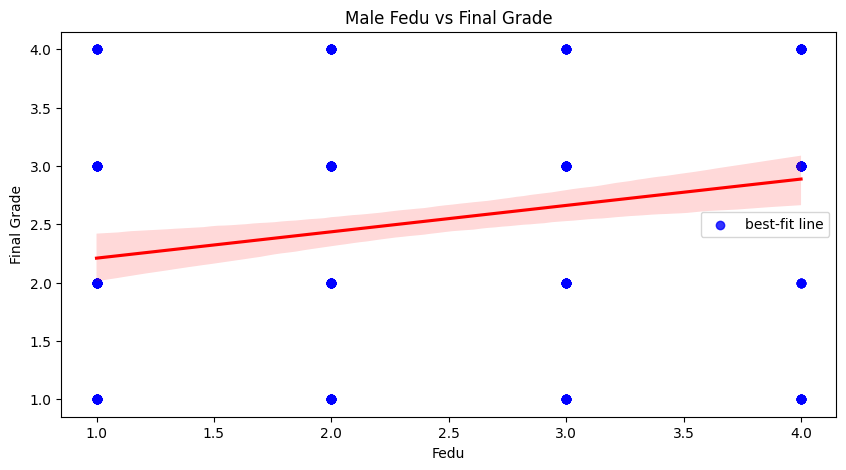

Pearson correlation between Medu and G3: 0.2545407747558637


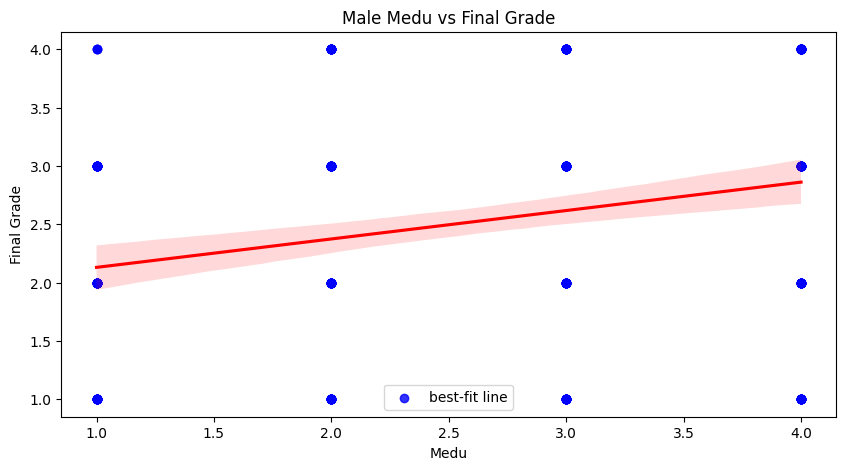

Pearson correlation between famrel and G3: 0.024187729538625132


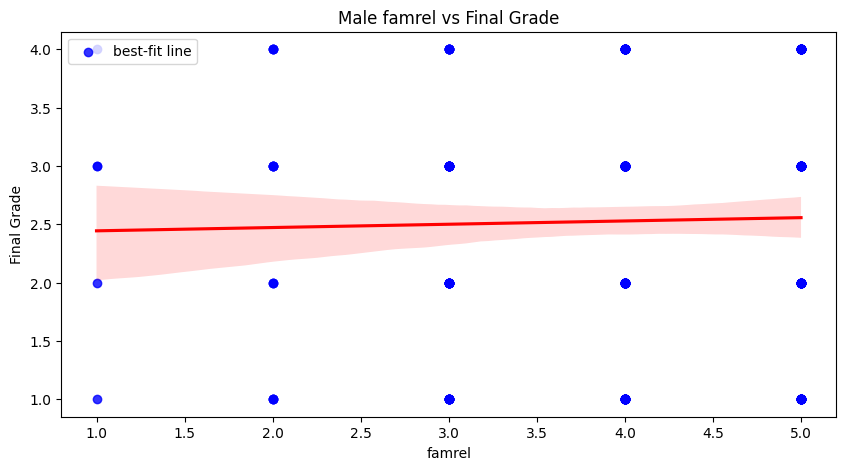

Pearson correlation between Fedu and G3: 0.09577821185835801


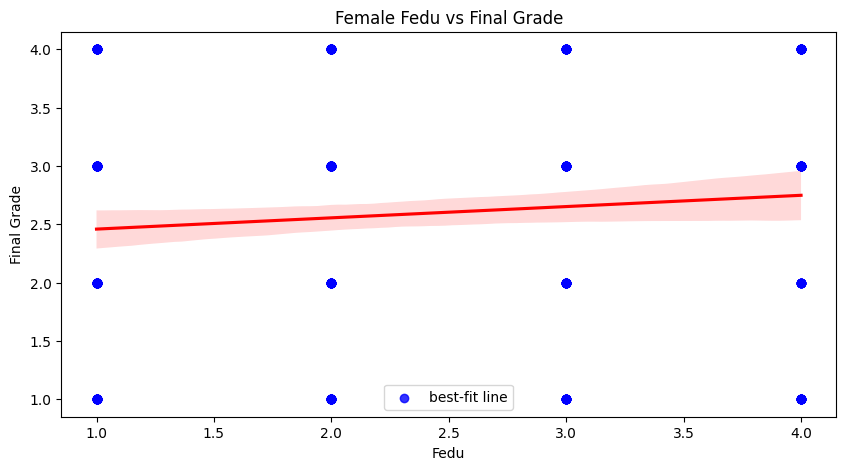

Pearson correlation between Medu and G3: 0.1421447263776128


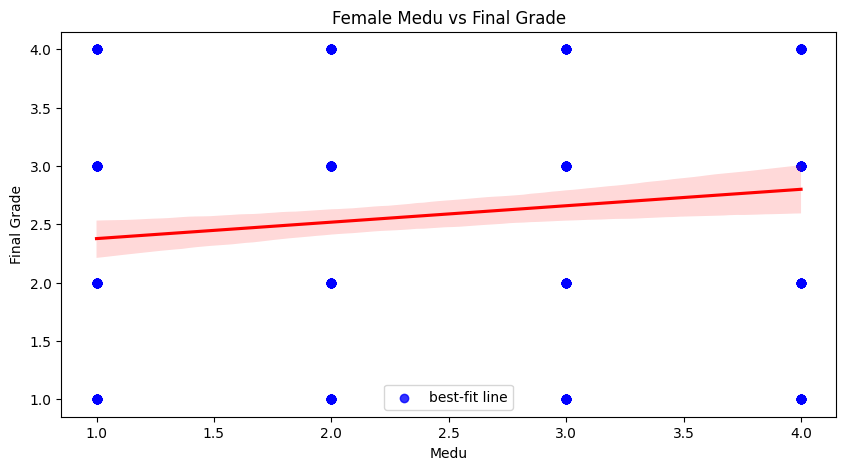

Pearson correlation between famrel and G3: 0.0696833724710774


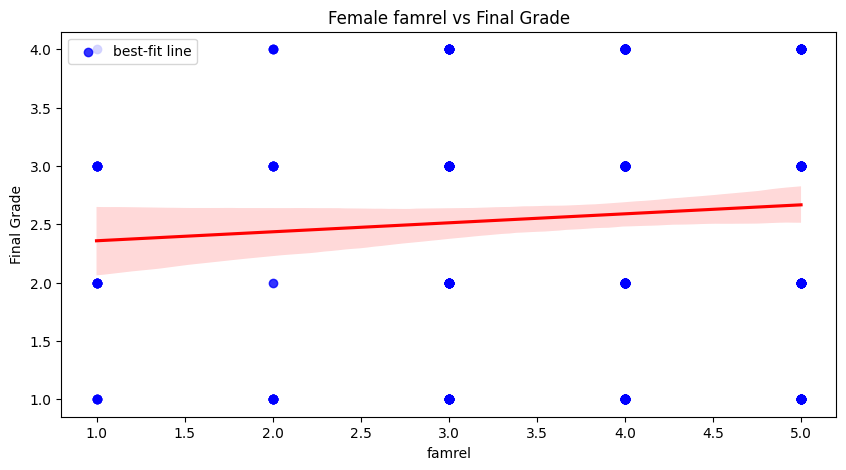

Pearson correlation between Fedu and G3: 0.14906830380631042


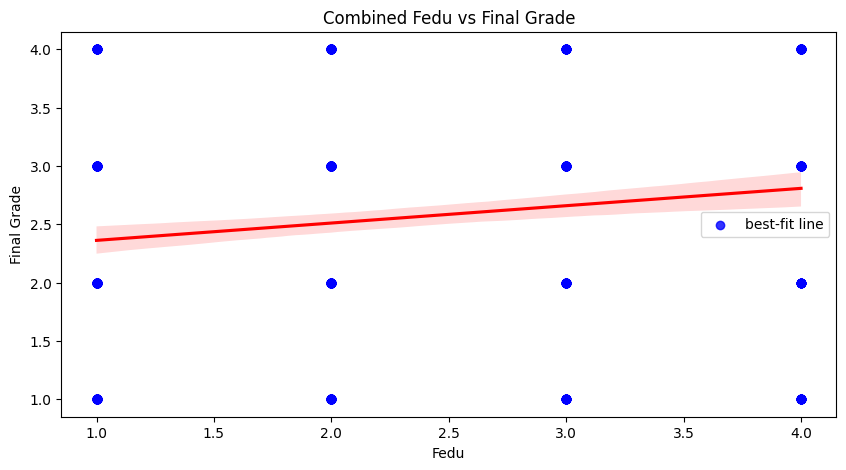

Pearson correlation between Medu and G3: 0.18656899977835803


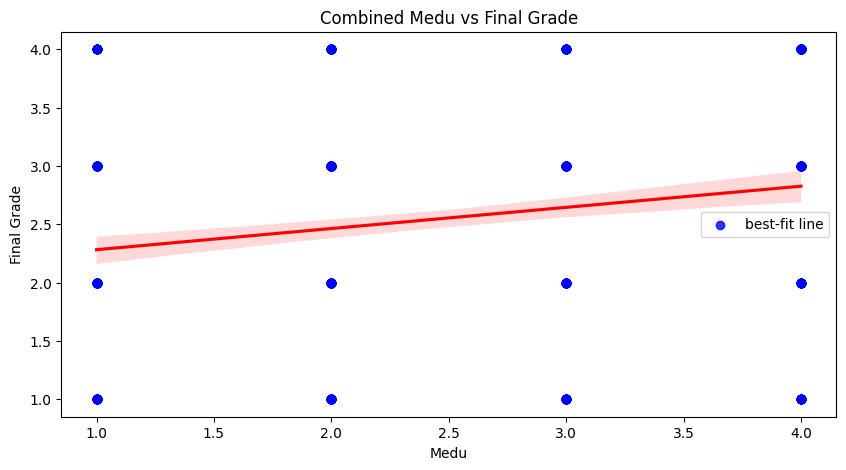

Pearson correlation between famrel and G3: 0.049522863901267984


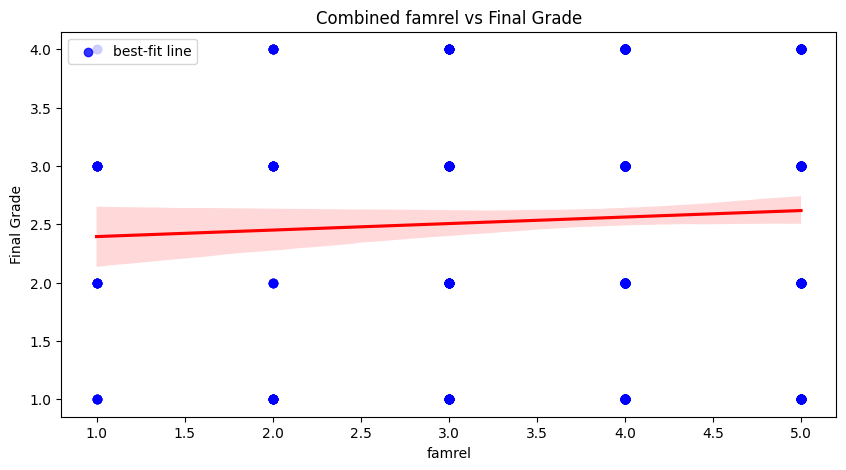

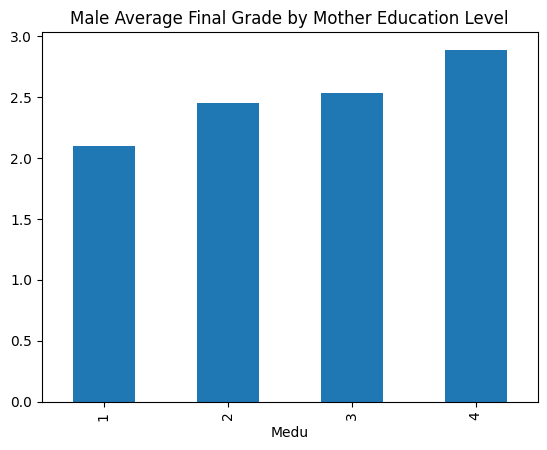

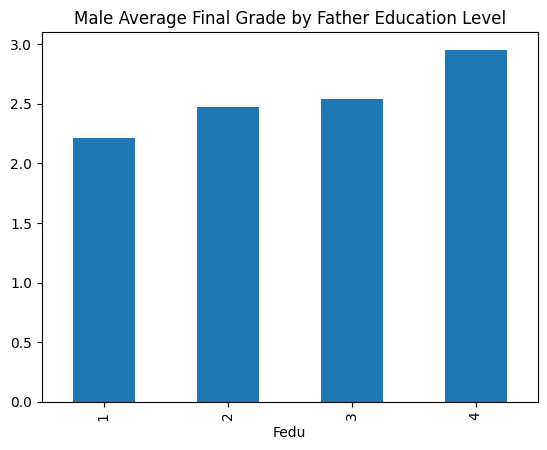

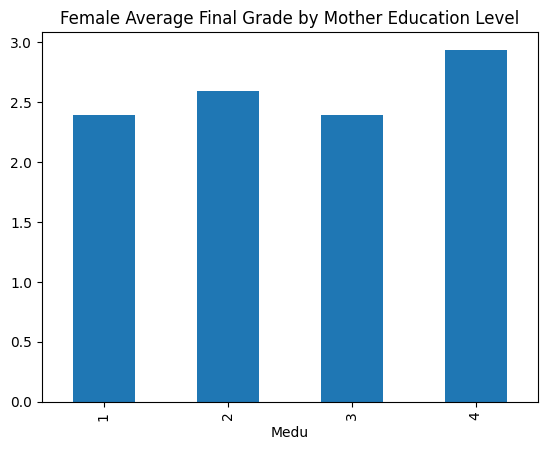

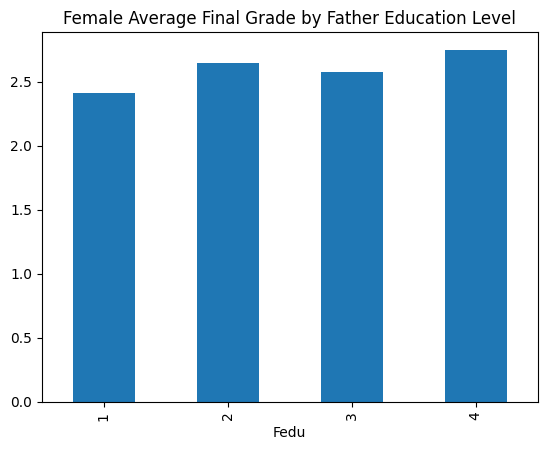

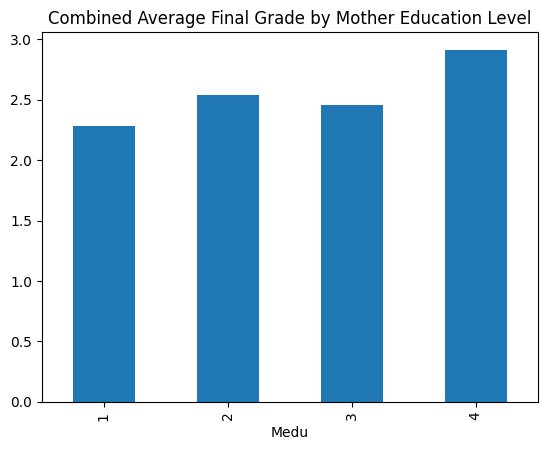

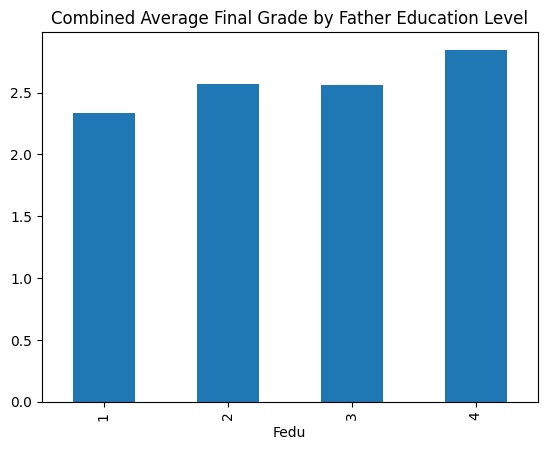

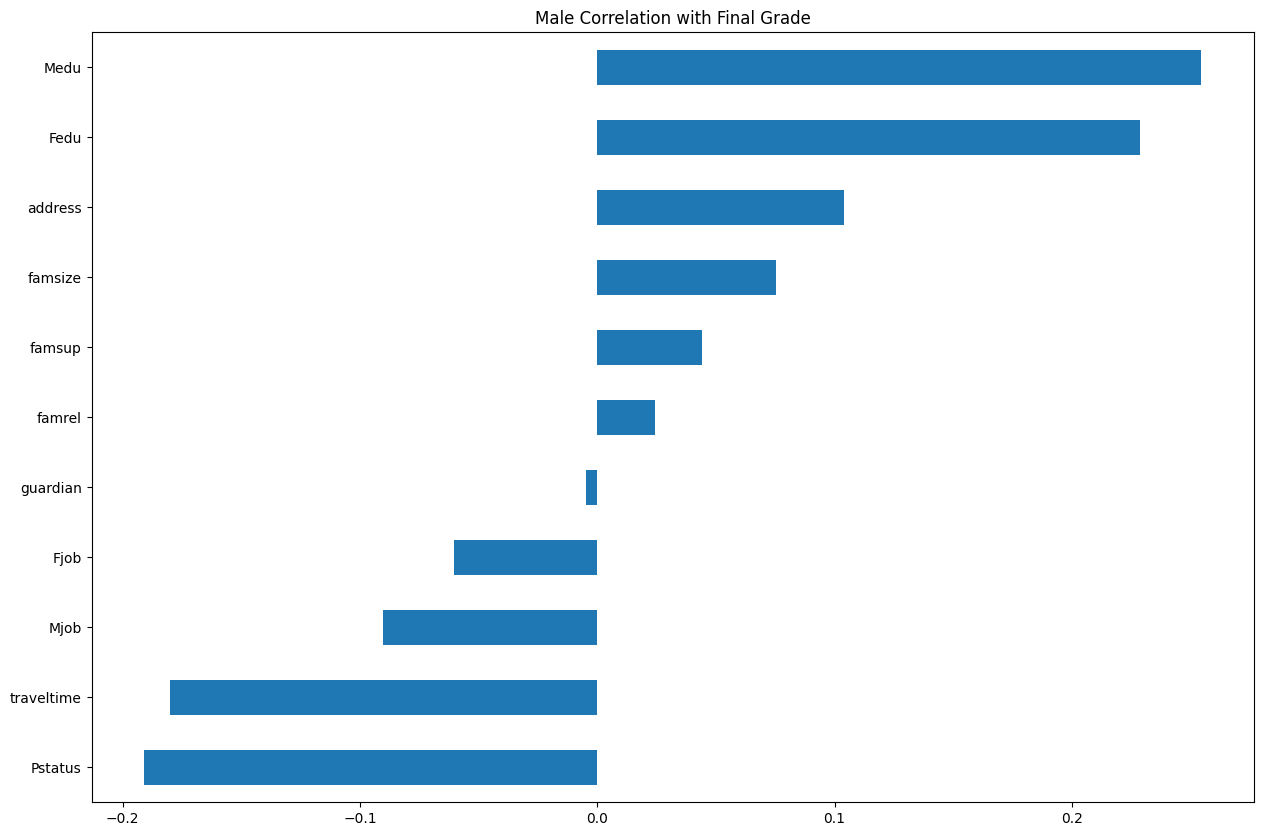

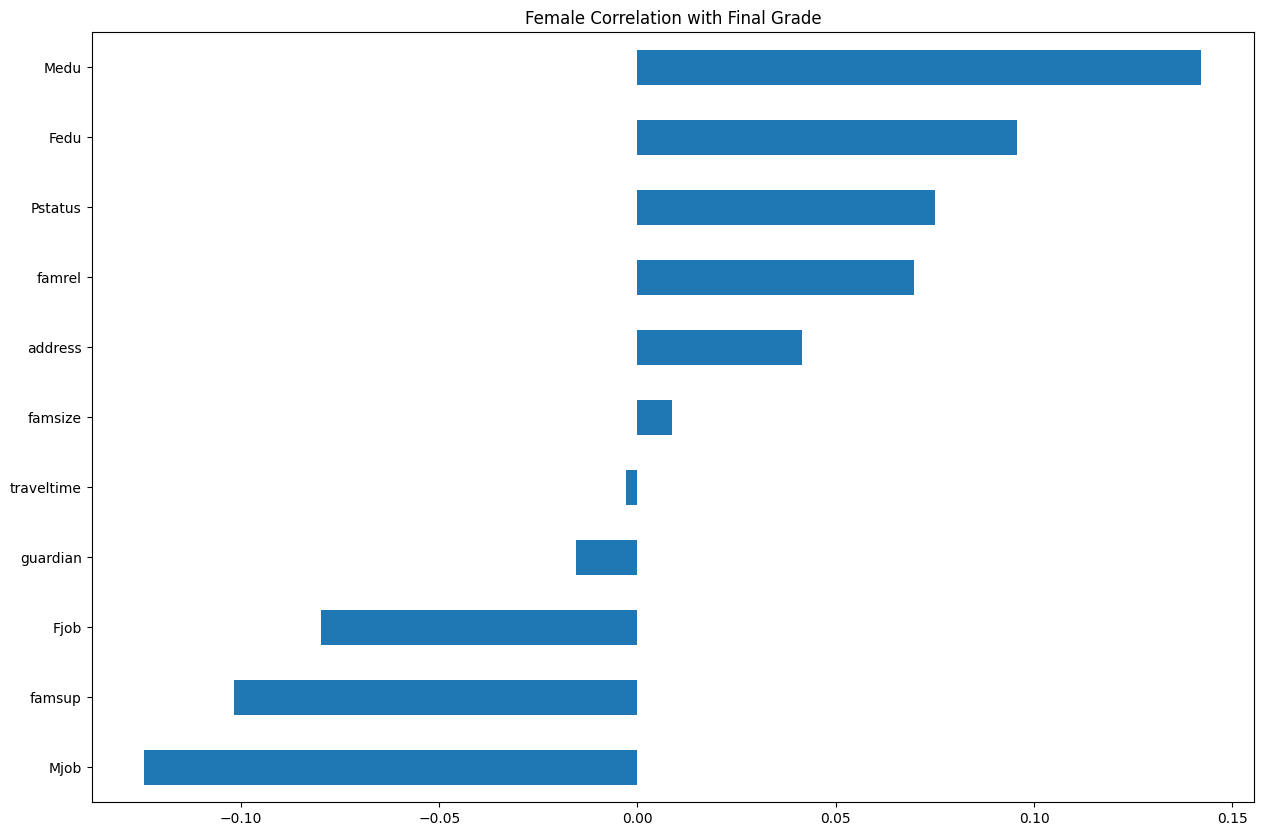

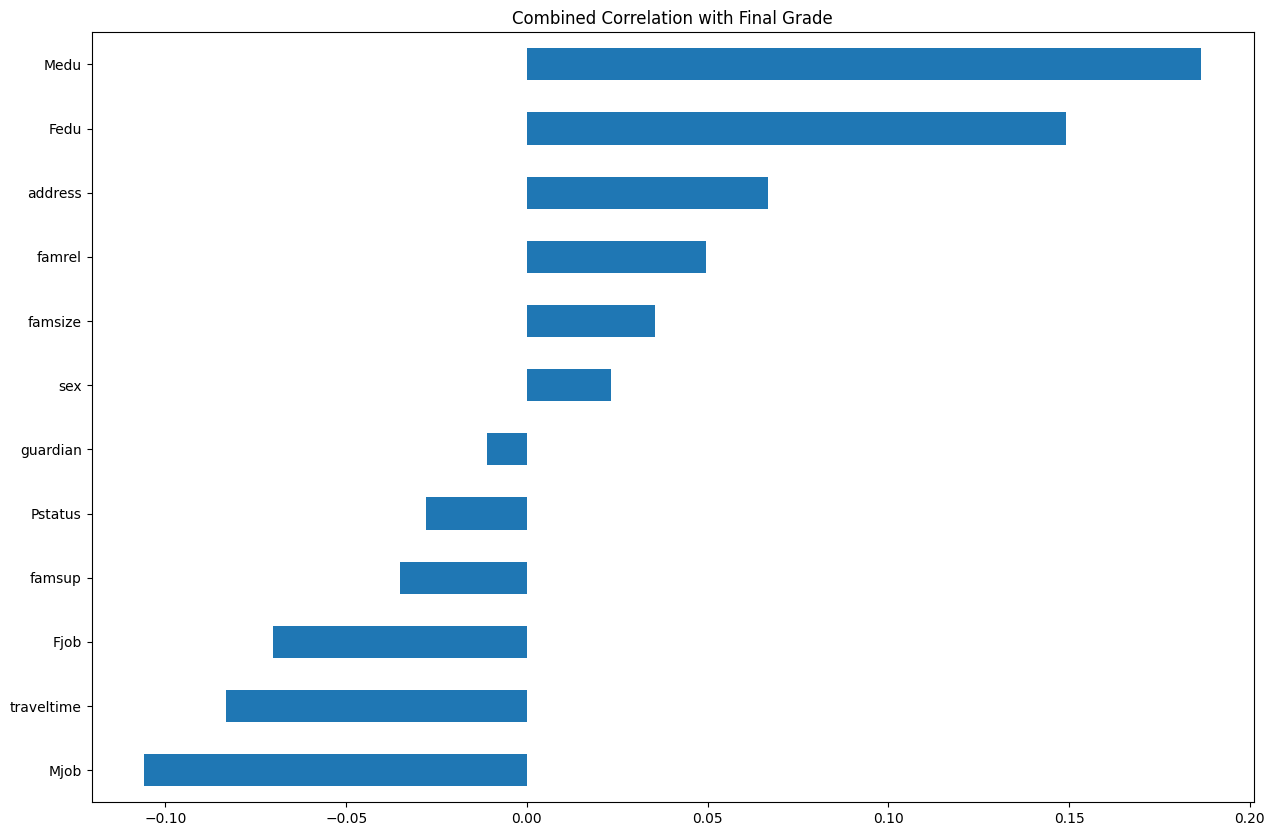

In [2]:
# Sampling libraries
from collections import Counter
from sklearn.model_selection import train_test_split
from Eda import *
from sklearn.utils import resample

# sklearn packages for Decision Tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 
from sklearn.metrics import roc_auc_score

# sklearn packages for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import StandardScaler

# sklearn packages for KNNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# sklearn packages for NN
from sklearn.neural_network import MLPClassifier

# Set print options
pd.set_option('display.max_columns', None)

from tqdm import tqdm

In [97]:
df_boys, df_girls, df = dataframes

#df_boys = df_boys[['famrel','Fjob', 'Mjob', 'Medu', 'Fedu','G3']]

#df_girls = df_girls[['famrel', 'Fedu', 'Medu','G3']]

df = df.drop(['sex'], axis=1)

#df = df[['famrel', 'Medu','G3']]

X = df.drop('G3', axis=1).values
y = df['G3'].values

x_boys = df_boys.drop('G3', axis=1).values
y_boys = df_boys['G3'].values

x_girls = df_girls.drop('G3', axis=1).values
y_girls = df_girls['G3'].values

In [8]:
def evaluate_model(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1).item()
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1).item()
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1).item()
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr').item()

    # Return the results
    return {
        'Model': model.__class__.__name__,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc_roc
    }

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(x_boys, y_boys, test_size=0.2, random_state=42)
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(x_girls, y_girls, test_size=0.2, random_state=42)

splitList = [[X_train_b, y_train_b, X_test_b, y_test_b], [X_train_g, y_train_g, X_test_g, y_test_g], [X_train, y_train, X_test, y_test]]

In [10]:
# plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
def fitModel(model):
	results = []
	feature_importances = []
	predictions = []
	for split in splitList:
		model.fit(split[0], split[1])
		result = evaluate_model(model, split[2], split[3])
		predictions.append(model.predict(split[2]))
		results.append(result)
		feature_importances.append(model.feature_importances_)
	return results, feature_importances, predictions

In [26]:
def scalerFitModel(model):
    results = []
    permutation_importances = []
    predictions = []
    for split in splitList:
        scaler = StandardScaler()
        scaler.fit(split[0])
        X_train_std = scaler.transform(split[0])
        X_test_std = scaler.transform(split[2])
        model.fit(X_train_std, split[1])
        result = evaluate_model(model, X_test_std, split[3])
        results.append(result)
        predictions.append(model.predict(split[2]))
        result = permutation_importance(model, X_test_std, split[3], scoring='accuracy')
        permutation_importances.append(result.importances_mean)
    return results, permutation_importances, predictions

In [13]:
def evaluateModel(models):
    results = []
    for prediction in models:
        results.append(evaluate_model(prediction[0], prediction[1], prediction[2]))
    return results

In [14]:
def predictModel(model):
    results = []
    for split in splitList:
        results.append(model.predict(split[2]))
    return results

In [15]:
def plot_feature_importance(featImportLst, extraTitle = ''):
    fig, ax = plt.subplots(ncols=1, figsize=(15, 5))
    fig.suptitle(f'{extraTitle} Feature Importance for Different Dataframes')

    features = df[['address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'guardian', 'traveltime', 'famsup', 'famrel']].columns
    importances = featImportLst
    indices = np.argsort(importances)

    ax.barh(features[indices], importances[indices])
    ax.set(xlabel='Importance', ylabel='Feature', title='Feature Importance')

    fig.tight_layout()
    plt.show()

In [16]:
def returnGender(split):
    return 'Male' if split is splitList[0] else 'Female' if split is splitList[1] else 'Combined'

#### Decision tree

In [67]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=df.columns.size - 2)
results, feature_importance, clf_predictions = fitModel(clf)
results

[{'Model': 'DecisionTreeClassifier',
  'Accuracy': 0.32786885245901637,
  'Precision': 0.5004383273428596,
  'Recall': 0.32786885245901637,
  'F1 Score': 0.27296709399731567,
  'AUC': 0.5824830685820428},
 {'Model': 'DecisionTreeClassifier',
  'Accuracy': 0.32926829268292684,
  'Precision': 0.3521099496709253,
  'Recall': 0.32926829268292684,
  'F1 Score': 0.29187282229965156,
  'AUC': 0.49357185782967034},
 {'Model': 'DecisionTreeClassifier',
  'Accuracy': 0.36619718309859156,
  'Precision': 0.536358894105373,
  'Recall': 0.36619718309859156,
  'F1 Score': 0.31596367351592475,
  'AUC': 0.5719116215705806}]

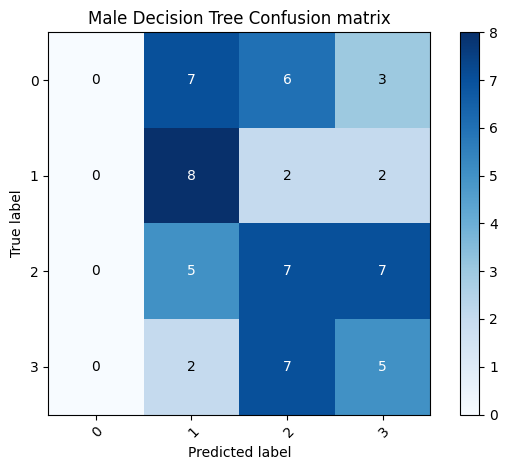

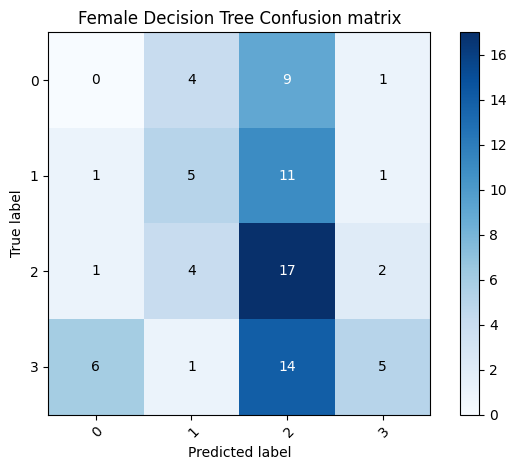

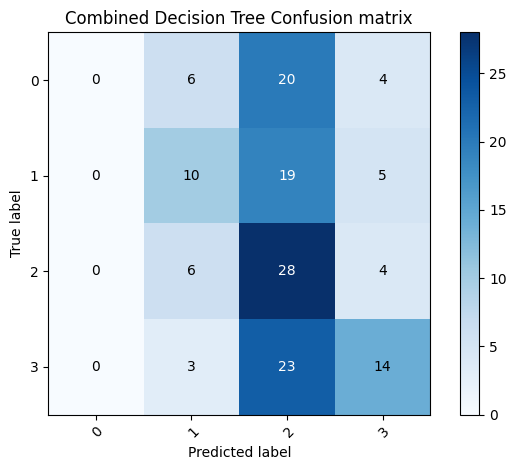

In [68]:
for s, p in zip(splitList, clf_predictions):
    plot_confusion_matrix(s[3], p, classes=['0', '1', '2', '3'], normalize=False, title=f'{returnGender(s)} Decision Tree Confusion matrix')
    plt.show()

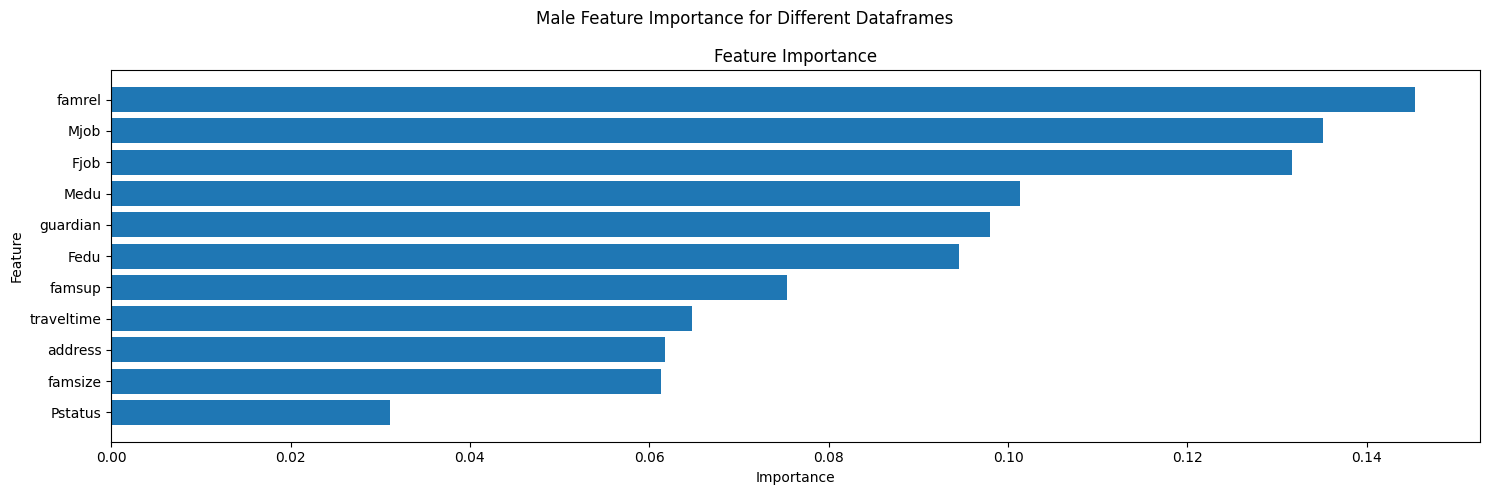

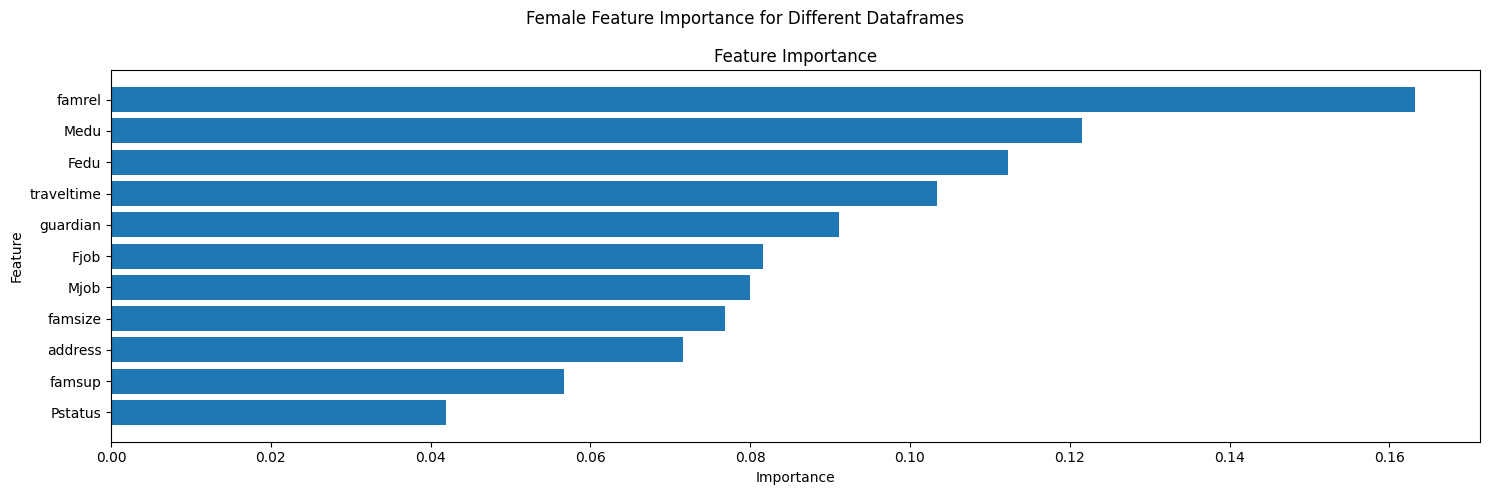

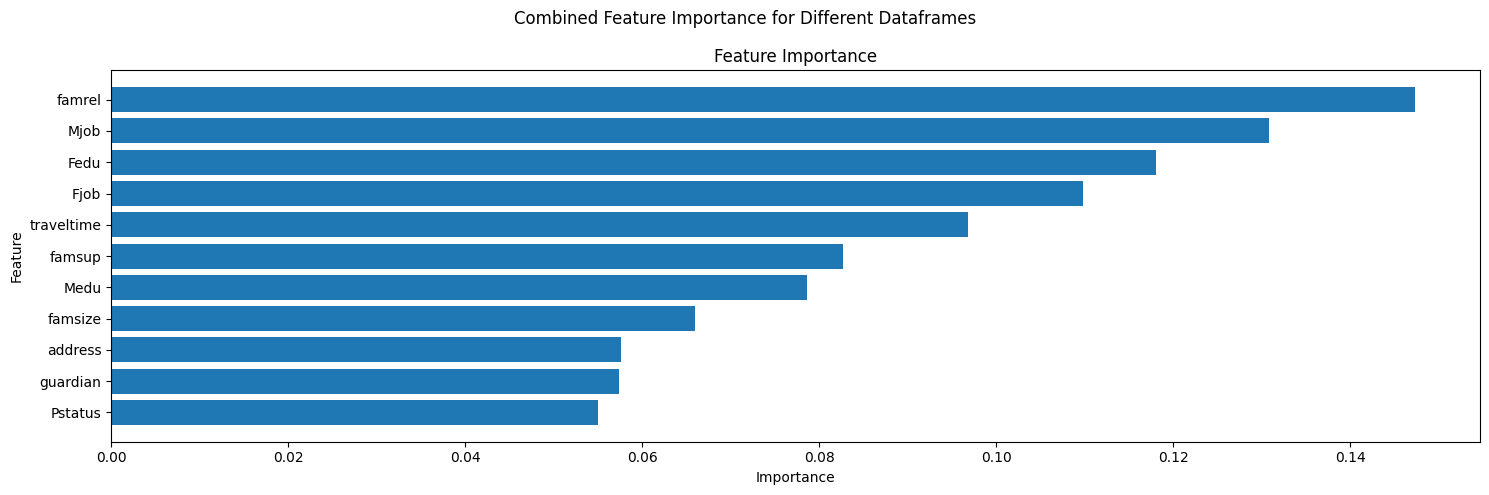

In [39]:
for s, m in zip(splitList, feature_importance):
    plot_feature_importance(m, extraTitle=returnGender(s))

#### Random Forest

In [98]:
rf = RandomForestClassifier()
rf_results, rf_feature_importance, rf_predictions = fitModel(rf)
rf_results

[{'Model': 'RandomForestClassifier',
  'Accuracy': 0.26229508196721313,
  'Precision': 0.25346083788706736,
  'Recall': 0.26229508196721313,
  'F1 Score': 0.2443241779796339,
  'AUC': 0.5417498319316528},
 {'Model': 'RandomForestClassifier',
  'Accuracy': 0.3902439024390244,
  'Precision': 0.40494937635711764,
  'Recall': 0.3902439024390244,
  'F1 Score': 0.3959170004289482,
  'AUC': 0.55647814635359},
 {'Model': 'RandomForestClassifier',
  'Accuracy': 0.2887323943661972,
  'Precision': 0.31654143631055043,
  'Recall': 0.2887323943661972,
  'F1 Score': 0.29455385079882346,
  'AUC': 0.5345436496123416}]

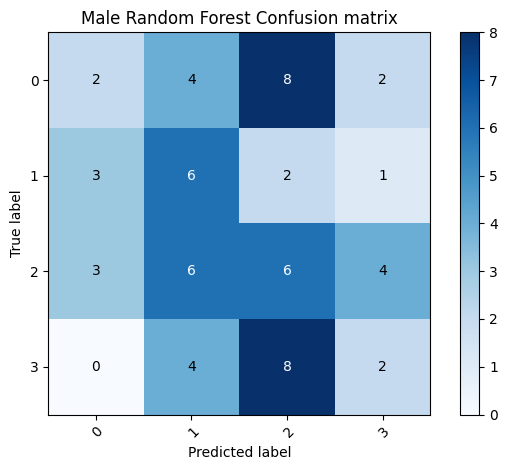

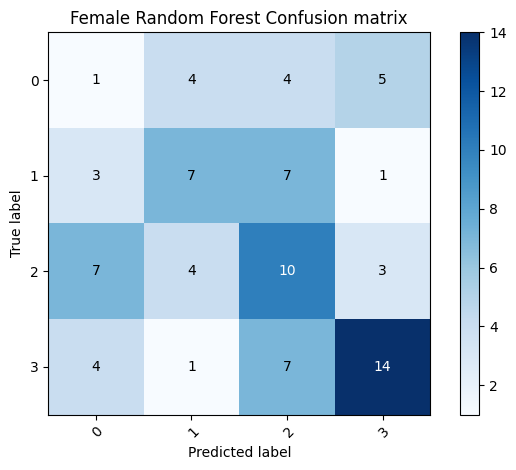

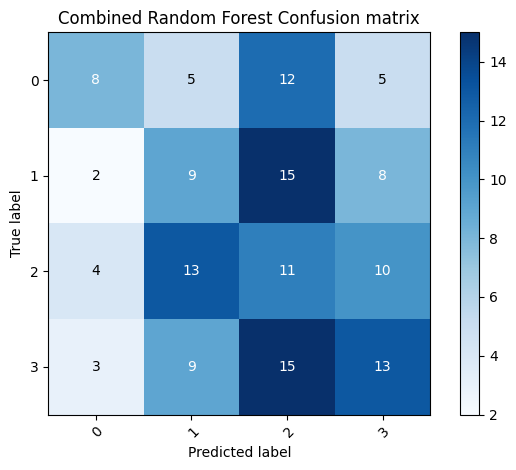

In [99]:
for s, p in zip(splitList, rf_predictions):
    plot_confusion_matrix(s[3], p, classes=['0', '1', '2', '3'], normalize=False, title=f'{returnGender(s)} Random Forest Confusion matrix')
    plt.show()

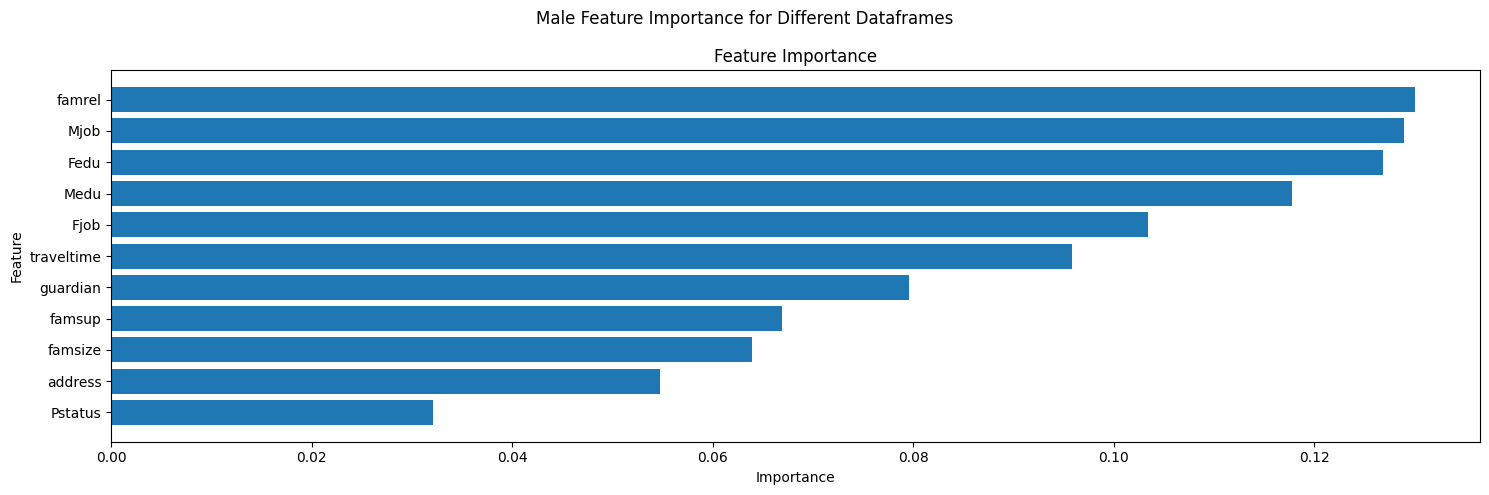

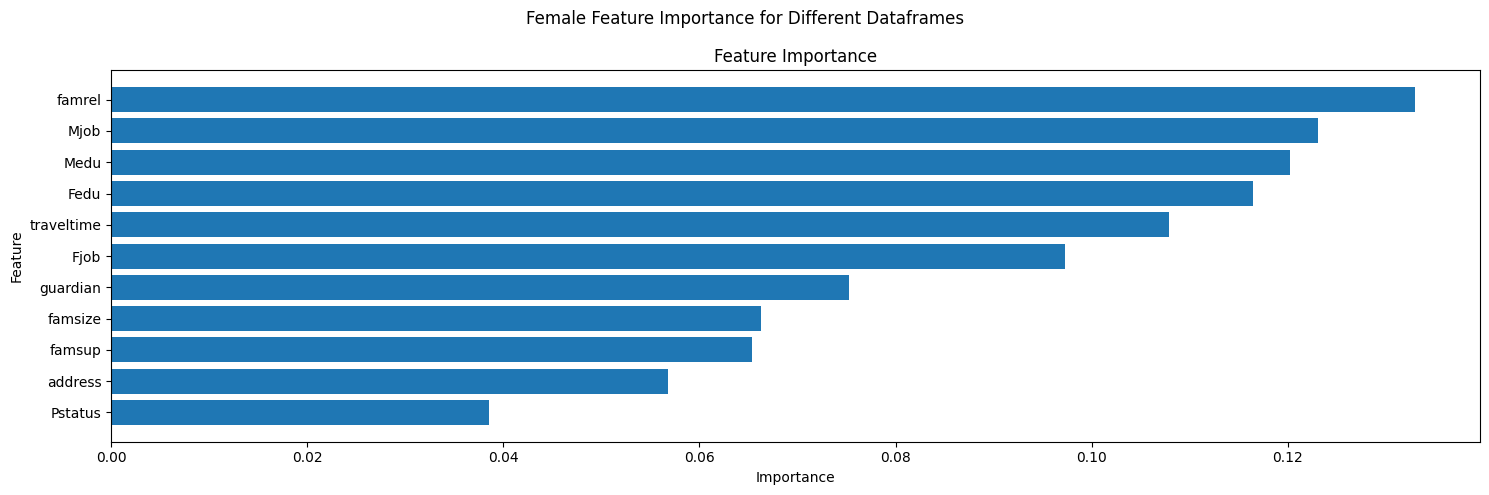

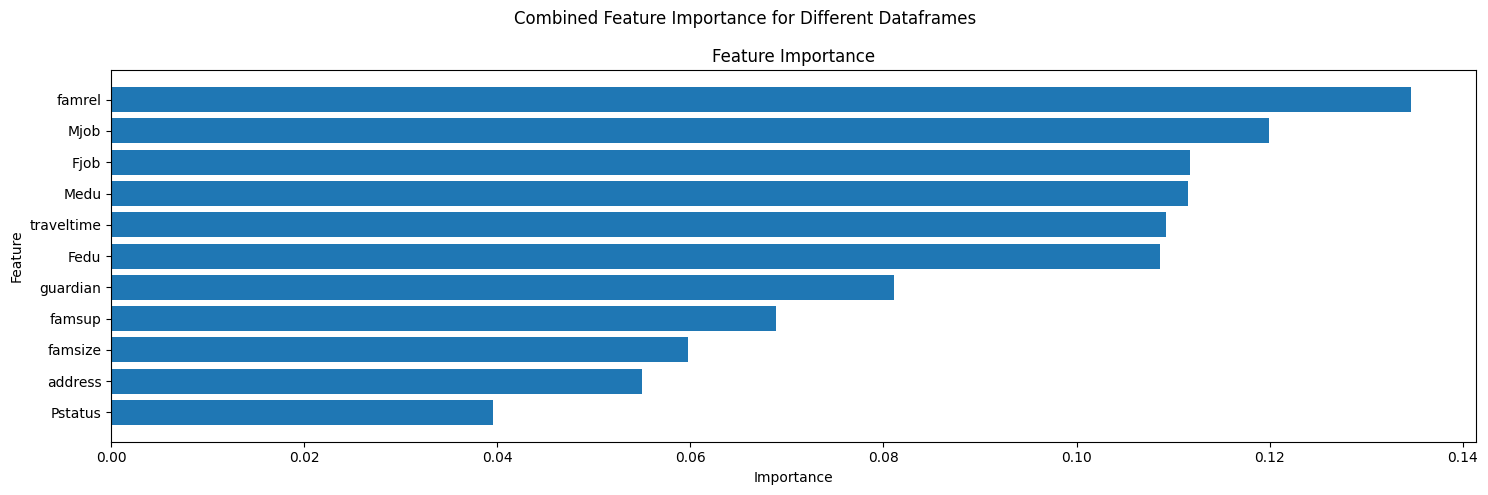

In [78]:
for s, m in zip(splitList, rf_feature_importance):
    plot_feature_importance(m, extraTitle=returnGender(s))

#### KNN

In [95]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')

knn_results, knn_feature_importance, knn_predictions = scalerFitModel(knn)
knn_results

[{'Model': 'KNeighborsClassifier',
  'Accuracy': 0.3770491803278688,
  'Precision': 0.37800723866297636,
  'Recall': 0.3770491803278688,
  'F1 Score': 0.3641891994358593,
  'AUC': 0.5757987967956872},
 {'Model': 'KNeighborsClassifier',
  'Accuracy': 0.34146341463414637,
  'Precision': 0.34064258911819884,
  'Recall': 0.34146341463414637,
  'F1 Score': 0.3406599713055954,
  'AUC': 0.49055956448118593},
 {'Model': 'KNeighborsClassifier',
  'Accuracy': 0.2605633802816901,
  'Precision': 0.25567292644757433,
  'Recall': 0.2605633802816901,
  'F1 Score': 0.2554431238594357,
  'AUC': 0.5384211219350539}]

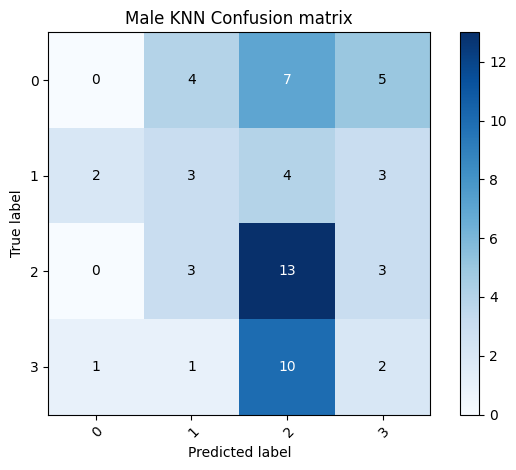

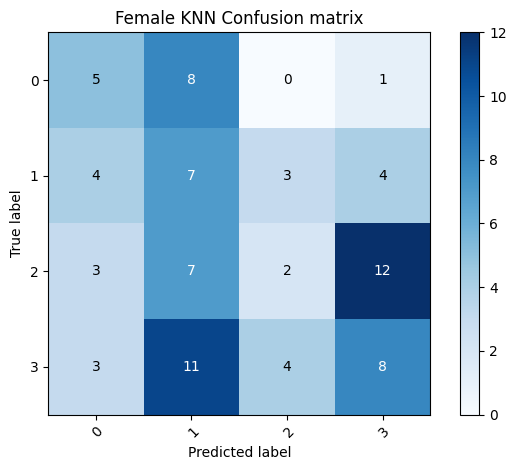

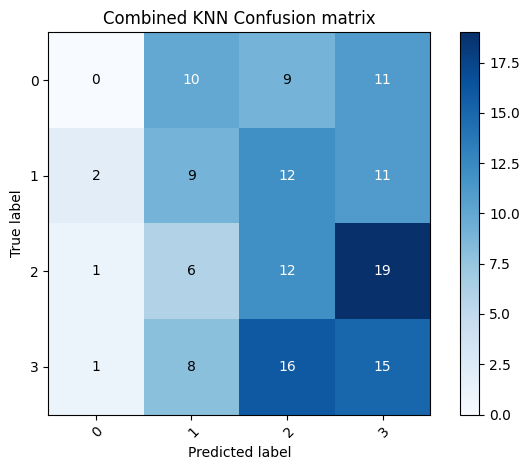

In [28]:
for s, p in zip(splitList, knn_predictions):
    plot_confusion_matrix(s[3], p, classes=['0', '1', '2', '3'], normalize=False, title=f'{returnGender(s)} KNN Confusion matrix')
    plt.show()

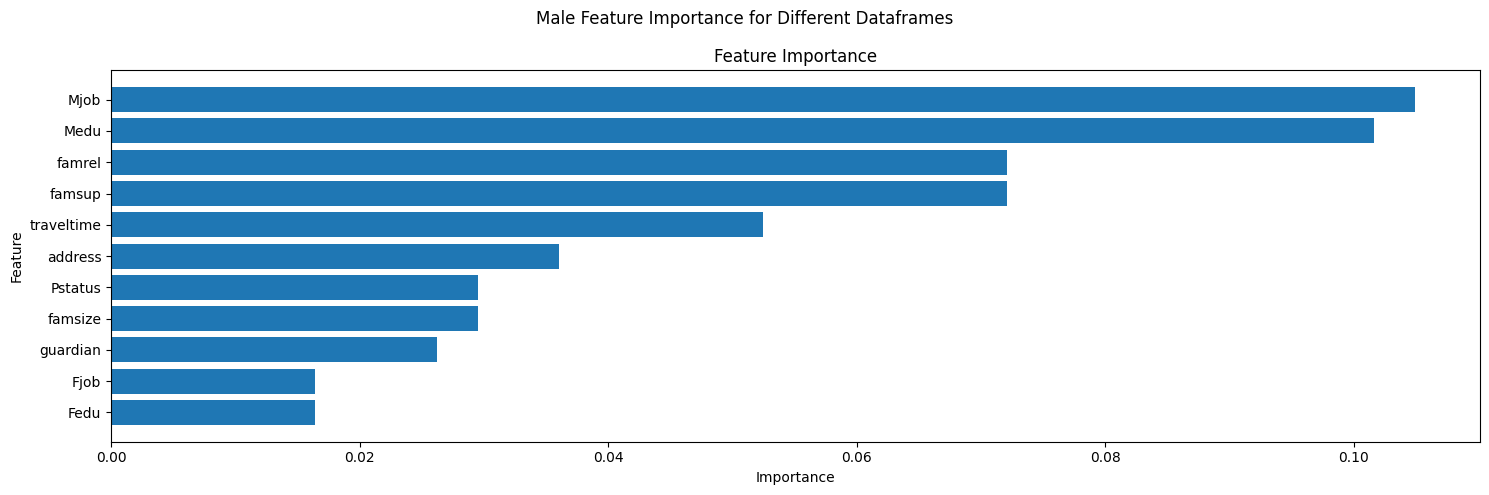

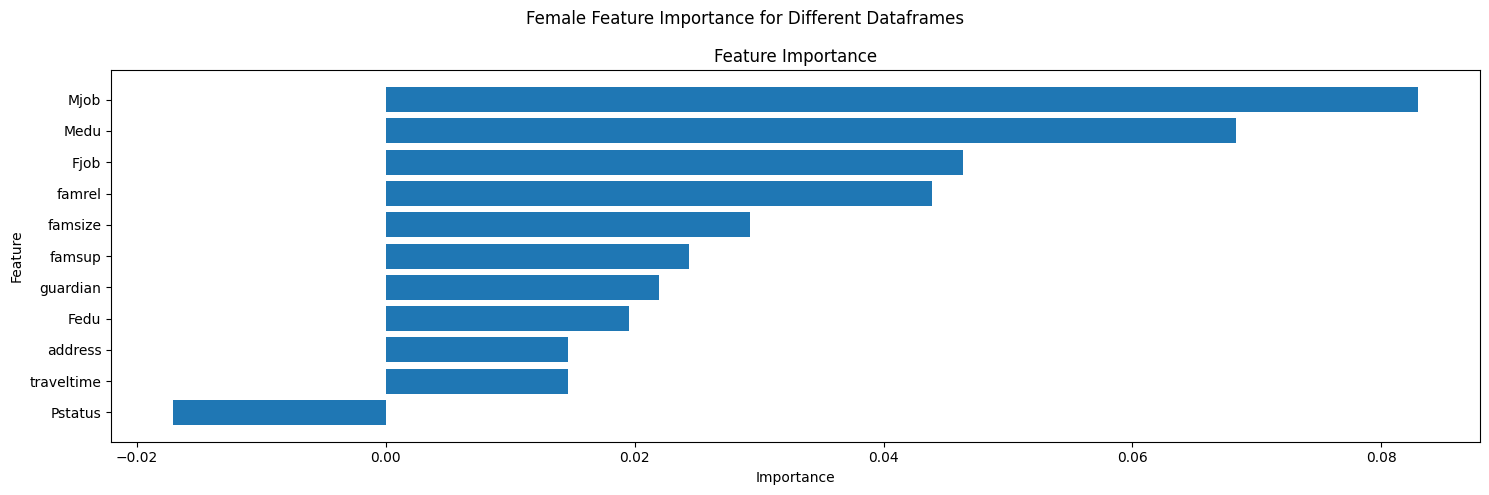

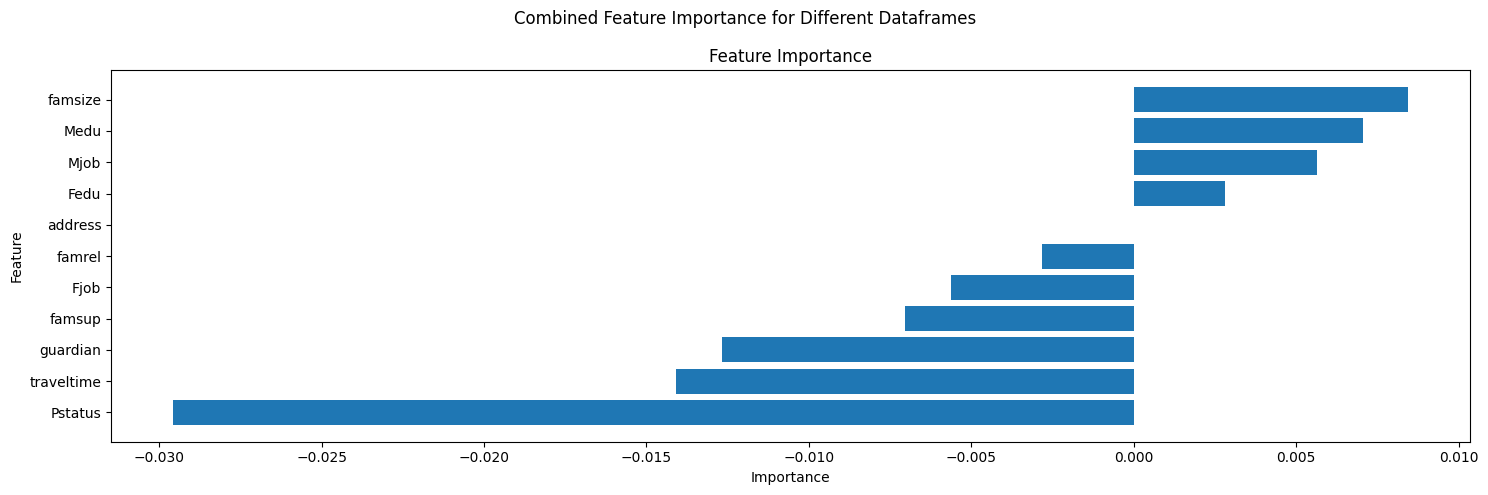

In [29]:
for s, m in zip(splitList, knn_feature_importance):
    plot_feature_importance(m, extraTitle=returnGender(s))

In [30]:
nn = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=10000, activation='logistic', solver='lbfgs', learning_rate='adaptive')

nn_results, nn_feature_importance, nn_predictions = scalerFitModel(nn)
nn_results

[{'Model': 'MLPClassifier',
  'Accuracy': 0.32786885245901637,
  'Precision': 0.3329129886506936,
  'Recall': 0.32786885245901637,
  'F1 Score': 0.32886093033068725,
  'AUC': 0.59108774342137},
 {'Model': 'MLPClassifier',
  'Accuracy': 0.2682926829268293,
  'Precision': 0.29551393728222997,
  'Recall': 0.2682926829268293,
  'F1 Score': 0.2745465916197623,
  'AUC': 0.4860498811040773},
 {'Model': 'MLPClassifier',
  'Accuracy': 0.2746478873239437,
  'Precision': 0.2757544504248987,
  'Recall': 0.2746478873239437,
  'F1 Score': 0.2732046074704767,
  'AUC': 0.5241155793738999}]

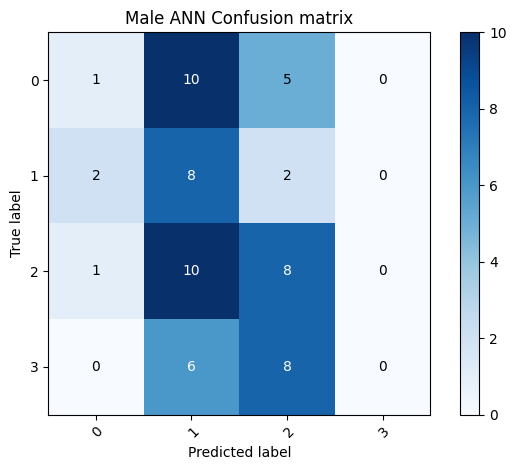

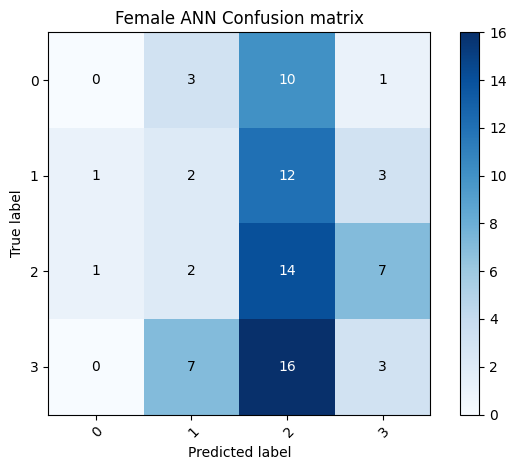

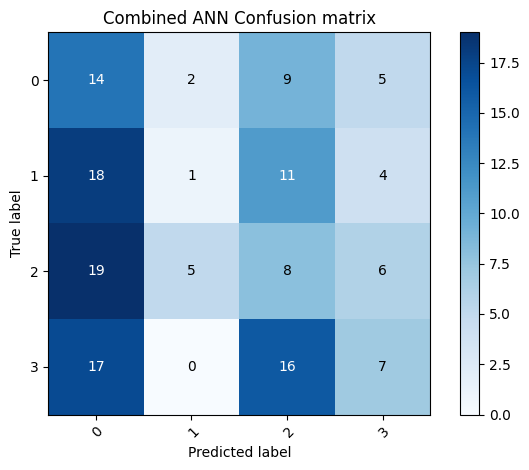

In [31]:
for s, p in zip(splitList, nn_predictions):
    plot_confusion_matrix(s[3], p, classes=['0', '1', '2', '3'], normalize=False, title=f'{returnGender(s)} ANN Confusion matrix')
    plt.show()

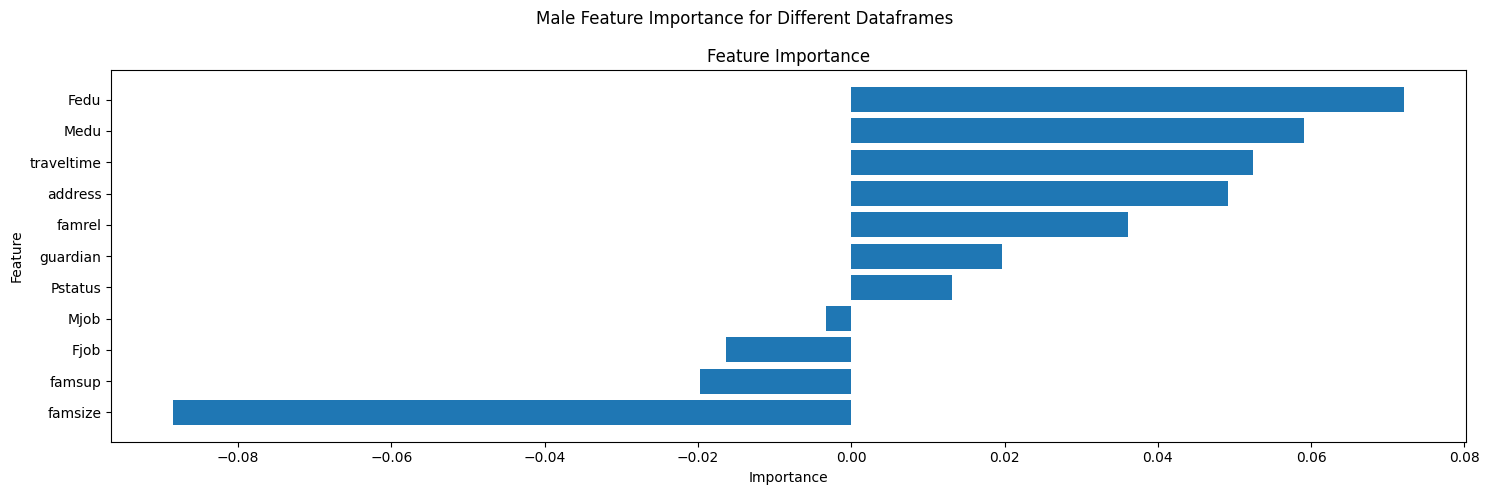

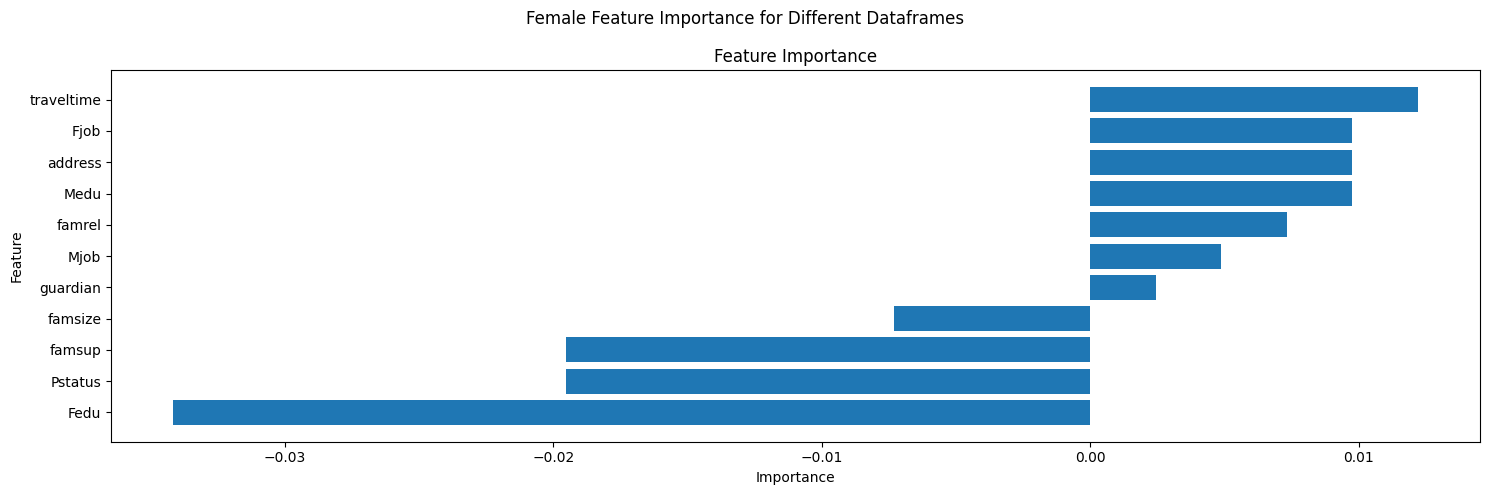

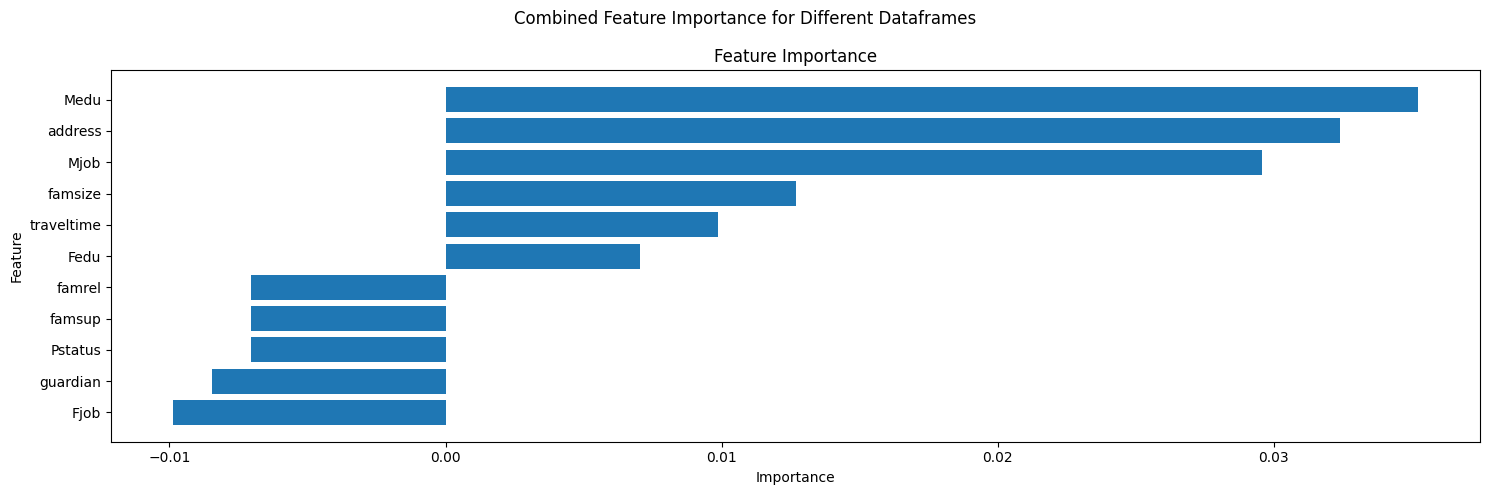

In [32]:
for s, m in zip(splitList, nn_feature_importance):
    plot_feature_importance(m, extraTitle=returnGender(s))

#### TODO:
1. Træn alle modeller på kønsfordelingen
2. Se importance features på de nye modeller
3. Vælg de vigtige features og træn modeller igen
4. NB: vigtige features kan også udvælges fra eda visualiseringerne.